# **Exercise B. GAN**

Second optional exercise for the Project of DLAI Fall semester 2019/2020.

Authors:
* Carlos Alejandro López Molina
* María González i Calabuig
* Roser Batlle Roca
* Jordi Biosca Caro

In [64]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 1).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

In [0]:
batch_size = 50
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self, batch_size):
        super(Generator, self).__init__()
        self._fc = torch.nn.Linear(1, 1024*4*4)
        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x):
        # Noise to image
        x = self._fc(x)
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4))

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks(batch_size)
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self, batch_size):
        # create networks
        self._generator = Generator(batch_size)
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
            
        # TODO: generate fake samples out of the random noise z
        fake_samples = self._generator(z)
        return fake_samples
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, label):
        # generate fake samples
        fake_samples = self.generate_samples(real_samples.size(0))
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples, label)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, fake_samples.detach(), label)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, real_label):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # TODO: Calculate generator loss
        estim_fake = self._discriminator(fake_samples)
        loss = self._criterion(estim_fake, real_label)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples, real_label):
        # Reset gradients
        self._opt_d.zero_grad()

        # TODO: Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples)
        loss_real = self._criterion(estim_real, real_label)

        # TODO: Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        

In [0]:
num_epochs = 100
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(batch_size)

epoch: 0/100, batch: 0/1200, G_loss: 0.7152113914489746, D_loss: (0.7037298083305359, 0.6909453868865967)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


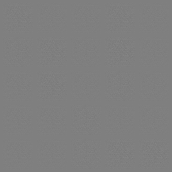

epoch: 0/100, batch: 10/1200, G_loss: -1.3244668245315552, D_loss: (-1.2542475461959839, 0.9709068536758423)
epoch: 0/100, batch: 20/1200, G_loss: -2.0795016288757324, D_loss: (-2.0882554054260254, 1.3031206130981445)
epoch: 0/100, batch: 30/1200, G_loss: -5.064172744750977, D_loss: (-5.148370265960693, 1.7214248180389404)
epoch: 0/100, batch: 40/1200, G_loss: -6.971353530883789, D_loss: (-7.5143561363220215, 2.272353410720825)
epoch: 0/100, batch: 50/1200, G_loss: -8.884732246398926, D_loss: (-10.175716400146484, 2.909510612487793)


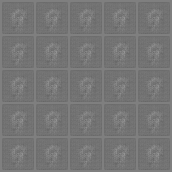

epoch: 0/100, batch: 60/1200, G_loss: -11.868171691894531, D_loss: (-15.0427827835083, 3.425473690032959)
epoch: 0/100, batch: 70/1200, G_loss: -14.17176628112793, D_loss: (-19.164098739624023, 4.380411624908447)
epoch: 0/100, batch: 80/1200, G_loss: -18.468368530273438, D_loss: (-24.286460876464844, 5.259886264801025)
epoch: 0/100, batch: 90/1200, G_loss: -24.24219512939453, D_loss: (-33.18080520629883, 6.139138221740723)
epoch: 0/100, batch: 100/1200, G_loss: -23.8772029876709, D_loss: (-32.39732360839844, 8.006027221679688)


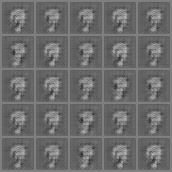

epoch: 0/100, batch: 110/1200, G_loss: -27.007848739624023, D_loss: (-55.18315887451172, 6.261879920959473)
epoch: 0/100, batch: 120/1200, G_loss: -18.498455047607422, D_loss: (-58.93565368652344, 5.868570327758789)
epoch: 0/100, batch: 130/1200, G_loss: -13.551074028015137, D_loss: (-48.9955940246582, 4.842012882232666)
epoch: 0/100, batch: 140/1200, G_loss: -42.085697174072266, D_loss: (-68.72714233398438, 14.165355682373047)
epoch: 0/100, batch: 150/1200, G_loss: -19.356046676635742, D_loss: (-82.81643676757812, 5.045718669891357)


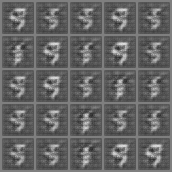

epoch: 0/100, batch: 160/1200, G_loss: -28.809650421142578, D_loss: (-74.5818862915039, 9.842141151428223)
epoch: 0/100, batch: 170/1200, G_loss: -5.119997978210449, D_loss: (-77.91655731201172, 1.8048382997512817)
epoch: 0/100, batch: 180/1200, G_loss: -19.981731414794922, D_loss: (-81.06034851074219, 6.869791030883789)
epoch: 0/100, batch: 190/1200, G_loss: 0.9561623930931091, D_loss: (-89.1884765625, 1.0209167003631592)
epoch: 0/100, batch: 200/1200, G_loss: -85.65617370605469, D_loss: (-84.74880981445312, 27.631019592285156)


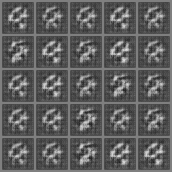

epoch: 0/100, batch: 210/1200, G_loss: -98.91905212402344, D_loss: (-98.91905212402344, 27.631019592285156)
epoch: 0/100, batch: 220/1200, G_loss: -79.02471923828125, D_loss: (-79.49226379394531, 27.631019592285156)
epoch: 0/100, batch: 230/1200, G_loss: -83.44568634033203, D_loss: (-83.94095611572266, 27.631019592285156)
epoch: 0/100, batch: 240/1200, G_loss: -90.62974548339844, D_loss: (-92.4013900756836, 27.631019592285156)
epoch: 0/100, batch: 250/1200, G_loss: -124.89221954345703, D_loss: (-125.42491912841797, 27.631019592285156)


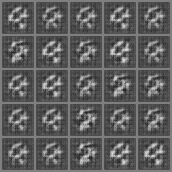

epoch: 0/100, batch: 260/1200, G_loss: -92.8402328491211, D_loss: (-92.89568328857422, 27.631019592285156)
epoch: 0/100, batch: 270/1200, G_loss: -91.182373046875, D_loss: (-90.98815155029297, 27.631019592285156)
epoch: 0/100, batch: 280/1200, G_loss: -108.31360626220703, D_loss: (-104.89187622070312, 27.631019592285156)
epoch: 0/100, batch: 290/1200, G_loss: -77.36685943603516, D_loss: (-78.2364501953125, 27.631019592285156)
epoch: 0/100, batch: 300/1200, G_loss: -75.70899200439453, D_loss: (-76.10353088378906, 27.631019592285156)


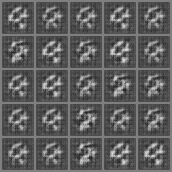

epoch: 0/100, batch: 310/1200, G_loss: -102.78739929199219, D_loss: (-102.50237274169922, 27.631019592285156)
epoch: 0/100, batch: 320/1200, G_loss: -90.0771255493164, D_loss: (-91.68344116210938, 27.631019592285156)
epoch: 0/100, batch: 330/1200, G_loss: -100.57691192626953, D_loss: (-102.28939819335938, 27.631019592285156)
epoch: 0/100, batch: 340/1200, G_loss: -94.49809265136719, D_loss: (-94.4673080444336, 27.631019592285156)
epoch: 0/100, batch: 350/1200, G_loss: -91.73497772216797, D_loss: (-93.28871154785156, 27.631019592285156)


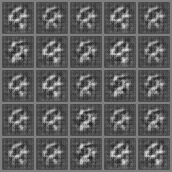

epoch: 0/100, batch: 360/1200, G_loss: -89.5245132446289, D_loss: (-91.01628875732422, 27.631019592285156)
epoch: 0/100, batch: 370/1200, G_loss: -88.97189331054688, D_loss: (-89.39610290527344, 27.631019592285156)
epoch: 0/100, batch: 380/1200, G_loss: -109.97146606445312, D_loss: (-110.79290008544922, 27.631019592285156)
epoch: 0/100, batch: 390/1200, G_loss: -96.15596008300781, D_loss: (-95.84601593017578, 27.631019592285156)
epoch: 0/100, batch: 400/1200, G_loss: -100.02429962158203, D_loss: (-101.73487091064453, 27.631019592285156)


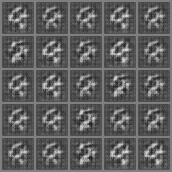

epoch: 0/100, batch: 410/1200, G_loss: -100.02429962158203, D_loss: (-101.84608459472656, 27.631019592285156)
epoch: 0/100, batch: 420/1200, G_loss: -116.05029296875, D_loss: (-111.55011749267578, 27.631019592285156)
epoch: 0/100, batch: 430/1200, G_loss: -96.70857238769531, D_loss: (-96.21508026123047, 27.631019592285156)
epoch: 0/100, batch: 440/1200, G_loss: -102.23478698730469, D_loss: (-104.3525390625, 27.631019592285156)
epoch: 0/100, batch: 450/1200, G_loss: -105.55050659179688, D_loss: (-104.10755157470703, 27.631019592285156)


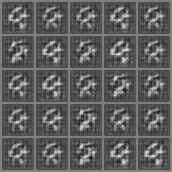

epoch: 0/100, batch: 460/1200, G_loss: -88.97188568115234, D_loss: (-90.23176574707031, 27.631019592285156)
epoch: 0/100, batch: 470/1200, G_loss: -91.73499298095703, D_loss: (-91.57306671142578, 27.631019592285156)
epoch: 0/100, batch: 480/1200, G_loss: -96.70857238769531, D_loss: (-97.99564361572266, 27.631019592285156)
epoch: 0/100, batch: 490/1200, G_loss: -91.182373046875, D_loss: (-91.02165985107422, 27.631019592285156)
epoch: 0/100, batch: 500/1200, G_loss: -96.70857238769531, D_loss: (-100.20650482177734, 27.631019592285156)


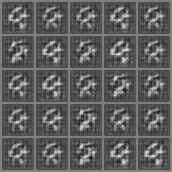

epoch: 0/100, batch: 510/1200, G_loss: -81.23519897460938, D_loss: (-80.6150894165039, 27.631019592285156)
epoch: 0/100, batch: 520/1200, G_loss: -101.1295394897461, D_loss: (-101.6524429321289, 27.631019592285156)
epoch: 0/100, batch: 530/1200, G_loss: -80.68258666992188, D_loss: (-79.48286437988281, 27.631019592285156)
epoch: 0/100, batch: 540/1200, G_loss: -100.02429962158203, D_loss: (-101.9160385131836, 27.631019592285156)
epoch: 0/100, batch: 550/1200, G_loss: -101.68215942382812, D_loss: (-103.11388397216797, 27.631019592285156)


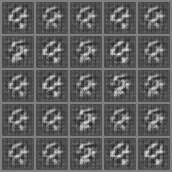

epoch: 0/100, batch: 560/1200, G_loss: -116.60291290283203, D_loss: (-117.46613311767578, 27.631019592285156)
epoch: 0/100, batch: 570/1200, G_loss: -80.12995910644531, D_loss: (-82.0729751586914, 27.631019592285156)
epoch: 0/100, batch: 580/1200, G_loss: -96.70857238769531, D_loss: (-96.02803039550781, 27.631019592285156)
epoch: 0/100, batch: 590/1200, G_loss: -102.23477172851562, D_loss: (-102.09967803955078, 27.631019592285156)
epoch: 0/100, batch: 600/1200, G_loss: -99.4716796875, D_loss: (-99.5741195678711, 27.631019592285156)


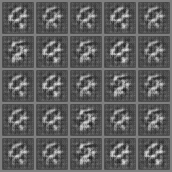

epoch: 0/100, batch: 610/1200, G_loss: -91.182373046875, D_loss: (-90.48007202148438, 27.631019592285156)
epoch: 0/100, batch: 620/1200, G_loss: -75.70899200439453, D_loss: (-77.36672973632812, 27.631019592285156)
epoch: 0/100, batch: 630/1200, G_loss: -86.20878601074219, D_loss: (-87.75708770751953, 27.631019592285156)
epoch: 0/100, batch: 640/1200, G_loss: -87.31402587890625, D_loss: (-89.44591522216797, 27.631019592285156)
epoch: 0/100, batch: 650/1200, G_loss: -89.5245132446289, D_loss: (-91.71307373046875, 27.631019592285156)


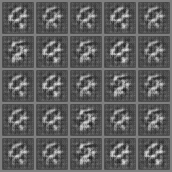

epoch: 0/100, batch: 660/1200, G_loss: -108.86621856689453, D_loss: (-110.7863998413086, 27.631019592285156)
epoch: 0/100, batch: 670/1200, G_loss: -89.52450561523438, D_loss: (-84.92053985595703, 27.631019592285156)
epoch: 0/100, batch: 680/1200, G_loss: -103.89263916015625, D_loss: (-105.17959594726562, 27.631019592285156)
epoch: 0/100, batch: 690/1200, G_loss: -84.5509262084961, D_loss: (-86.68680572509766, 27.631019592285156)
epoch: 0/100, batch: 700/1200, G_loss: -77.91947937011719, D_loss: (-80.13467407226562, 27.631019592285156)


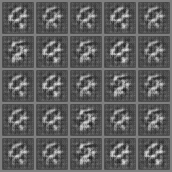

epoch: 0/100, batch: 710/1200, G_loss: -115.49767303466797, D_loss: (-117.06912231445312, 27.631019592285156)
epoch: 0/100, batch: 720/1200, G_loss: -91.182373046875, D_loss: (-94.48489379882812, 27.631019592285156)
epoch: 0/100, batch: 730/1200, G_loss: -109.97146606445312, D_loss: (-110.22810363769531, 27.631019592285156)
epoch: 0/100, batch: 740/1200, G_loss: -86.20878601074219, D_loss: (-87.83562469482422, 27.631019592285156)
epoch: 0/100, batch: 750/1200, G_loss: -69.63017272949219, D_loss: (-72.63713073730469, 27.631019592285156)


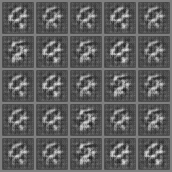

epoch: 0/100, batch: 760/1200, G_loss: -106.6557388305664, D_loss: (-107.71379089355469, 27.631019592285156)
epoch: 0/100, batch: 770/1200, G_loss: -102.78739929199219, D_loss: (-102.2560043334961, 27.631019592285156)
epoch: 0/100, batch: 780/1200, G_loss: -93.94546508789062, D_loss: (-96.89232635498047, 27.631019592285156)
epoch: 0/100, batch: 790/1200, G_loss: -90.0771255493164, D_loss: (-93.0665054321289, 27.631019592285156)
epoch: 0/100, batch: 800/1200, G_loss: -100.57691192626953, D_loss: (-102.24469757080078, 27.631019592285156)


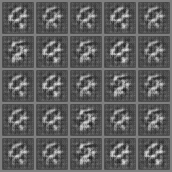

epoch: 0/100, batch: 810/1200, G_loss: -90.0771255493164, D_loss: (-93.05570983886719, 27.631019592285156)
epoch: 0/100, batch: 820/1200, G_loss: -109.4188461303711, D_loss: (-111.47671508789062, 27.631019592285156)
epoch: 0/100, batch: 830/1200, G_loss: -101.12953186035156, D_loss: (-104.4399185180664, 27.631019592285156)
epoch: 0/100, batch: 840/1200, G_loss: -87.31402587890625, D_loss: (-86.39529418945312, 27.631019592285156)
epoch: 0/100, batch: 850/1200, G_loss: -91.73499298095703, D_loss: (-92.70496368408203, 27.631019592285156)


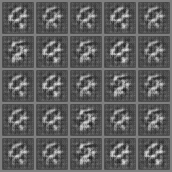

epoch: 0/100, batch: 860/1200, G_loss: -92.8402328491211, D_loss: (-91.89619445800781, 27.631019592285156)
epoch: 0/100, batch: 870/1200, G_loss: -113.28718566894531, D_loss: (-107.52486419677734, 27.631019592285156)
epoch: 0/100, batch: 880/1200, G_loss: -109.4188461303711, D_loss: (-112.03832244873047, 27.631019592285156)
epoch: 0/100, batch: 890/1200, G_loss: -95.05070495605469, D_loss: (-96.7261734008789, 27.631019592285156)
epoch: 0/100, batch: 900/1200, G_loss: -71.28804016113281, D_loss: (-75.11730194091797, 27.631019592285156)


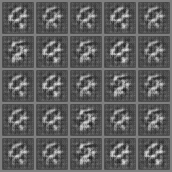

epoch: 0/100, batch: 910/1200, G_loss: -78.47209930419922, D_loss: (-81.05123138427734, 27.631019592285156)
epoch: 0/100, batch: 920/1200, G_loss: -86.76140594482422, D_loss: (-87.22579956054688, 27.631019592285156)
epoch: 0/100, batch: 930/1200, G_loss: -67.41969299316406, D_loss: (-70.2017593383789, 27.631019592285156)
epoch: 0/100, batch: 940/1200, G_loss: -100.02429962158203, D_loss: (-101.7177505493164, 27.631019592285156)
epoch: 0/100, batch: 950/1200, G_loss: -107.20835876464844, D_loss: (-108.07998657226562, 27.631019592285156)


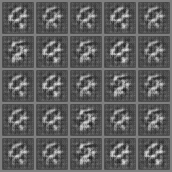

epoch: 0/100, batch: 960/1200, G_loss: -103.34001922607422, D_loss: (-104.92462158203125, 27.631019592285156)
epoch: 0/100, batch: 970/1200, G_loss: -121.02386474609375, D_loss: (-118.24737548828125, 27.631019592285156)
epoch: 0/100, batch: 980/1200, G_loss: -93.94546508789062, D_loss: (-93.94570922851562, 27.631019592285156)
epoch: 0/100, batch: 990/1200, G_loss: -95.60333251953125, D_loss: (-98.63078308105469, 27.631019592285156)
epoch: 0/100, batch: 1000/1200, G_loss: -102.23477172851562, D_loss: (-100.43816375732422, 27.631019592285156)


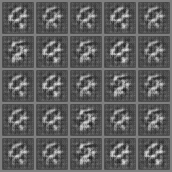

epoch: 0/100, batch: 1010/1200, G_loss: -104.44526672363281, D_loss: (-106.71746826171875, 27.631019592285156)
epoch: 0/100, batch: 1020/1200, G_loss: -95.05071258544922, D_loss: (-98.12802124023438, 27.631019592285156)
epoch: 0/100, batch: 1030/1200, G_loss: -97.26119232177734, D_loss: (-100.39974975585938, 27.631019592285156)
epoch: 0/100, batch: 1040/1200, G_loss: -91.73499298095703, D_loss: (-94.9942398071289, 27.631019592285156)
epoch: 0/100, batch: 1050/1200, G_loss: -81.78783416748047, D_loss: (-81.4156723022461, 27.631019592285156)


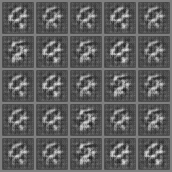

epoch: 0/100, batch: 1060/1200, G_loss: -88.97188568115234, D_loss: (-93.61963653564453, 27.631019592285156)
epoch: 0/100, batch: 1070/1200, G_loss: -108.31360626220703, D_loss: (-109.41107177734375, 27.631019592285156)
epoch: 0/100, batch: 1080/1200, G_loss: -114.39242553710938, D_loss: (-113.87324523925781, 27.631019592285156)
epoch: 0/100, batch: 1090/1200, G_loss: -88.41926574707031, D_loss: (-92.6825942993164, 27.631019592285156)
epoch: 0/100, batch: 1100/1200, G_loss: -85.65615844726562, D_loss: (-88.64969635009766, 27.631019592285156)


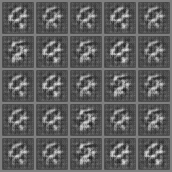

epoch: 0/100, batch: 1110/1200, G_loss: -93.94546508789062, D_loss: (-96.63734436035156, 27.631019592285156)
epoch: 0/100, batch: 1120/1200, G_loss: -90.62974548339844, D_loss: (-94.47834014892578, 27.631019592285156)
epoch: 0/100, batch: 1130/1200, G_loss: -111.62932586669922, D_loss: (-109.45252990722656, 27.631019592285156)
epoch: 0/100, batch: 1140/1200, G_loss: -124.89222717285156, D_loss: (-126.23607635498047, 27.631019592285156)
epoch: 0/100, batch: 1150/1200, G_loss: -83.44568634033203, D_loss: (-86.58679962158203, 27.631019592285156)


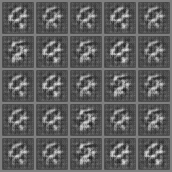

epoch: 0/100, batch: 1160/1200, G_loss: -97.81381225585938, D_loss: (-98.52005767822266, 27.631019592285156)
epoch: 0/100, batch: 1170/1200, G_loss: -108.86621856689453, D_loss: (-110.84064483642578, 27.631019592285156)
epoch: 0/100, batch: 1180/1200, G_loss: -118.81340026855469, D_loss: (-114.87945556640625, 27.631019592285156)
epoch: 0/100, batch: 1190/1200, G_loss: -99.4716796875, D_loss: (-103.17989349365234, 27.631019592285156)
epoch: 1/100, batch: 0/1200, G_loss: -110.52407836914062, D_loss: (-113.24378967285156, 27.631019592285156)


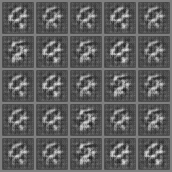

epoch: 1/100, batch: 10/1200, G_loss: -95.60333251953125, D_loss: (-95.98441314697266, 27.631019592285156)
epoch: 1/100, batch: 20/1200, G_loss: -83.44568634033203, D_loss: (-88.36267852783203, 27.631019592285156)
epoch: 1/100, batch: 30/1200, G_loss: -87.31402587890625, D_loss: (-90.91497802734375, 27.631019592285156)
epoch: 1/100, batch: 40/1200, G_loss: -90.0771255493164, D_loss: (-93.87897491455078, 27.631019592285156)
epoch: 1/100, batch: 50/1200, G_loss: -96.15596008300781, D_loss: (-98.18339538574219, 27.631019592285156)


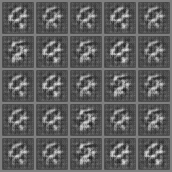

epoch: 1/100, batch: 60/1200, G_loss: -90.62974548339844, D_loss: (-92.47004699707031, 27.631019592285156)
epoch: 1/100, batch: 70/1200, G_loss: -93.94546508789062, D_loss: (-97.17840576171875, 27.631019592285156)
epoch: 1/100, batch: 80/1200, G_loss: -74.603759765625, D_loss: (-75.07687377929688, 27.631019592285156)
epoch: 1/100, batch: 90/1200, G_loss: -90.0771255493164, D_loss: (-91.1075210571289, 27.631019592285156)
epoch: 1/100, batch: 100/1200, G_loss: -92.8402328491211, D_loss: (-98.03699493408203, 27.631019592285156)


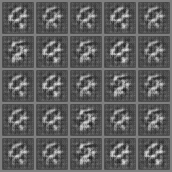

epoch: 1/100, batch: 110/1200, G_loss: -96.70857238769531, D_loss: (-97.7083969116211, 27.631019592285156)
epoch: 1/100, batch: 120/1200, G_loss: -103.89263916015625, D_loss: (-105.80835723876953, 27.631019592285156)
epoch: 1/100, batch: 130/1200, G_loss: -93.39285278320312, D_loss: (-95.44476318359375, 27.631019592285156)
epoch: 1/100, batch: 140/1200, G_loss: -86.20878601074219, D_loss: (-90.28746795654297, 27.631019592285156)
epoch: 1/100, batch: 150/1200, G_loss: -80.68257904052734, D_loss: (-81.7878189086914, 27.631019592285156)


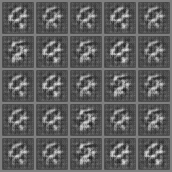

epoch: 1/100, batch: 160/1200, G_loss: -117.15552520751953, D_loss: (-119.35699462890625, 27.631019592285156)
epoch: 1/100, batch: 170/1200, G_loss: -100.57691192626953, D_loss: (-103.04415130615234, 27.631019592285156)
epoch: 1/100, batch: 180/1200, G_loss: -107.20836639404297, D_loss: (-109.94300842285156, 27.631019592285156)
epoch: 1/100, batch: 190/1200, G_loss: -98.3664321899414, D_loss: (-98.11988067626953, 27.631019592285156)
epoch: 1/100, batch: 200/1200, G_loss: -101.1295394897461, D_loss: (-103.86495971679688, 27.631019592285156)


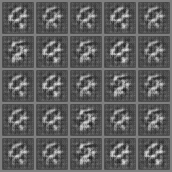

epoch: 1/100, batch: 210/1200, G_loss: -104.44526672363281, D_loss: (-104.44526672363281, 27.631019592285156)
epoch: 1/100, batch: 220/1200, G_loss: -109.97146606445312, D_loss: (-111.5615005493164, 27.631019592285156)
epoch: 1/100, batch: 230/1200, G_loss: -102.78739929199219, D_loss: (-105.52607727050781, 27.631019592285156)
epoch: 1/100, batch: 240/1200, G_loss: -103.89263916015625, D_loss: (-105.91382598876953, 27.631019592285156)
epoch: 1/100, batch: 250/1200, G_loss: -96.70857238769531, D_loss: (-100.30715942382812, 27.631019592285156)


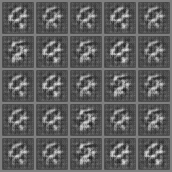

epoch: 1/100, batch: 260/1200, G_loss: -83.44568634033203, D_loss: (-85.06901550292969, 27.631019592285156)
epoch: 1/100, batch: 270/1200, G_loss: -99.4716796875, D_loss: (-101.12849426269531, 27.631019592285156)
epoch: 1/100, batch: 280/1200, G_loss: -108.8662338256836, D_loss: (-110.52362060546875, 27.631019592285156)
epoch: 1/100, batch: 290/1200, G_loss: -114.3924331665039, D_loss: (-115.4976577758789, 27.631019592285156)
epoch: 1/100, batch: 300/1200, G_loss: -107.20835876464844, D_loss: (-109.19719696044922, 27.631019592285156)


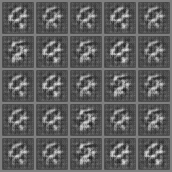

epoch: 1/100, batch: 310/1200, G_loss: -85.10354614257812, D_loss: (-89.49922180175781, 27.631019592285156)
epoch: 1/100, batch: 320/1200, G_loss: -122.6817398071289, D_loss: (-124.88854217529297, 27.631019592285156)
epoch: 1/100, batch: 330/1200, G_loss: -99.4716796875, D_loss: (-101.675537109375, 27.631019592285156)
epoch: 1/100, batch: 340/1200, G_loss: -99.4716796875, D_loss: (-101.65304565429688, 27.631019592285156)
epoch: 1/100, batch: 350/1200, G_loss: -99.47167205810547, D_loss: (-101.67483520507812, 27.631019592285156)


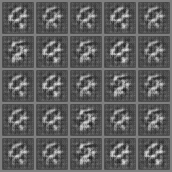

epoch: 1/100, batch: 360/1200, G_loss: -115.49766540527344, D_loss: (-116.60274505615234, 27.631019592285156)
epoch: 1/100, batch: 370/1200, G_loss: -94.49809265136719, D_loss: (-95.59143829345703, 27.631019592285156)
epoch: 1/100, batch: 380/1200, G_loss: -81.2352066040039, D_loss: (-85.55279541015625, 27.631019592285156)
epoch: 1/100, batch: 390/1200, G_loss: -106.1031265258789, D_loss: (-108.53917694091797, 27.631019592285156)
epoch: 1/100, batch: 400/1200, G_loss: -101.12953186035156, D_loss: (-102.63496398925781, 27.631019592285156)


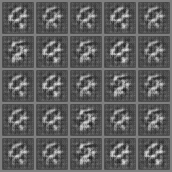

epoch: 1/100, batch: 410/1200, G_loss: -116.60291290283203, D_loss: (-117.70780944824219, 27.631019592285156)
epoch: 1/100, batch: 420/1200, G_loss: -85.65617370605469, D_loss: (-89.4493637084961, 27.631019592285156)
epoch: 1/100, batch: 430/1200, G_loss: -77.91947937011719, D_loss: (-81.5484619140625, 27.631019592285156)
epoch: 1/100, batch: 440/1200, G_loss: -85.10354614257812, D_loss: (-88.64232635498047, 27.631019592285156)
epoch: 1/100, batch: 450/1200, G_loss: -110.52407836914062, D_loss: (-112.18101501464844, 27.631019592285156)


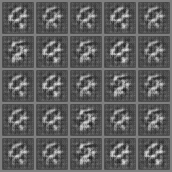

epoch: 1/100, batch: 460/1200, G_loss: -90.62974548339844, D_loss: (-93.874267578125, 27.631019592285156)
epoch: 1/100, batch: 470/1200, G_loss: -100.02429962158203, D_loss: (-102.08583068847656, 27.631019592285156)
epoch: 1/100, batch: 480/1200, G_loss: -103.34001922607422, D_loss: (-106.14834594726562, 27.631019592285156)
epoch: 1/100, batch: 490/1200, G_loss: -96.70857238769531, D_loss: (-99.2344741821289, 27.631019592285156)
epoch: 1/100, batch: 500/1200, G_loss: -109.4188461303711, D_loss: (-111.49608612060547, 27.631019592285156)


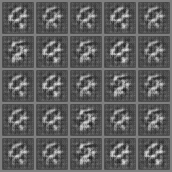

epoch: 1/100, batch: 510/1200, G_loss: -87.31402587890625, D_loss: (-90.1767578125, 27.631019592285156)
epoch: 1/100, batch: 520/1200, G_loss: -98.91905212402344, D_loss: (-99.9054946899414, 27.631019592285156)
epoch: 1/100, batch: 530/1200, G_loss: -76.2616195678711, D_loss: (-79.50440216064453, 27.631019592285156)
epoch: 1/100, batch: 540/1200, G_loss: -100.02429962158203, D_loss: (-101.38363647460938, 27.631019592285156)
epoch: 1/100, batch: 550/1200, G_loss: -84.5509262084961, D_loss: (-85.90161895751953, 27.631019592285156)


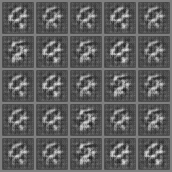

epoch: 1/100, batch: 560/1200, G_loss: -85.10354614257812, D_loss: (-87.74571990966797, 27.631019592285156)
epoch: 1/100, batch: 570/1200, G_loss: -100.57691192626953, D_loss: (-103.82146453857422, 27.631019592285156)
epoch: 1/100, batch: 580/1200, G_loss: -102.23477172851562, D_loss: (-103.33999633789062, 27.631019592285156)
epoch: 1/100, batch: 590/1200, G_loss: -81.7878189086914, D_loss: (-83.51861572265625, 27.631019592285156)
epoch: 1/100, batch: 600/1200, G_loss: -74.05113983154297, D_loss: (-76.58551788330078, 27.631019592285156)


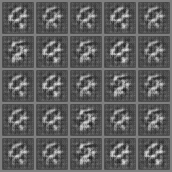

epoch: 1/100, batch: 610/1200, G_loss: -94.49809265136719, D_loss: (-96.10873413085938, 27.631019592285156)
epoch: 1/100, batch: 620/1200, G_loss: -104.44525146484375, D_loss: (-105.11160278320312, 27.631019592285156)
epoch: 1/100, batch: 630/1200, G_loss: -94.49808502197266, D_loss: (-97.18299102783203, 27.631019592285156)
epoch: 1/100, batch: 640/1200, G_loss: -80.12995910644531, D_loss: (-83.90191650390625, 27.631019592285156)
epoch: 1/100, batch: 650/1200, G_loss: -66.314453125, D_loss: (-69.58486938476562, 27.631019592285156)


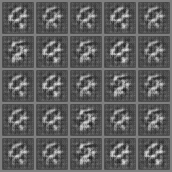

epoch: 1/100, batch: 660/1200, G_loss: -104.44526672363281, D_loss: (-103.28529357910156, 27.631019592285156)
epoch: 1/100, batch: 670/1200, G_loss: -106.6557388305664, D_loss: (-107.76091766357422, 27.631019592285156)
epoch: 1/100, batch: 680/1200, G_loss: -88.97189331054688, D_loss: (-92.5971450805664, 27.631019592285156)
epoch: 1/100, batch: 690/1200, G_loss: -106.10311889648438, D_loss: (-108.23298645019531, 27.631019592285156)
epoch: 1/100, batch: 700/1200, G_loss: -72.94589233398438, D_loss: (-76.25988006591797, 27.631019592285156)


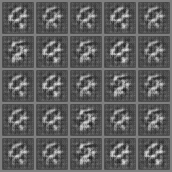

epoch: 1/100, batch: 710/1200, G_loss: -84.5509262084961, D_loss: (-87.02259063720703, 27.631019592285156)
epoch: 1/100, batch: 720/1200, G_loss: -95.05071258544922, D_loss: (-97.00450897216797, 27.631019592285156)
epoch: 1/100, batch: 730/1200, G_loss: -94.49808502197266, D_loss: (-96.03443145751953, 27.631019592285156)
epoch: 1/100, batch: 740/1200, G_loss: -102.78739929199219, D_loss: (-103.89263916015625, 27.631019592285156)
epoch: 1/100, batch: 750/1200, G_loss: -106.6557388305664, D_loss: (-108.18304443359375, 27.631019592285156)


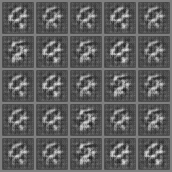

epoch: 1/100, batch: 760/1200, G_loss: -99.4716796875, D_loss: (-101.60993957519531, 27.631019592285156)
epoch: 1/100, batch: 770/1200, G_loss: -87.31402587890625, D_loss: (-91.39676666259766, 27.631019592285156)
epoch: 1/100, batch: 780/1200, G_loss: -104.44526672363281, D_loss: (-107.27885437011719, 27.631019592285156)
epoch: 1/100, batch: 790/1200, G_loss: -87.31402587890625, D_loss: (-89.5235824584961, 27.631019592285156)
epoch: 1/100, batch: 800/1200, G_loss: -100.57691192626953, D_loss: (-102.98091125488281, 27.631019592285156)


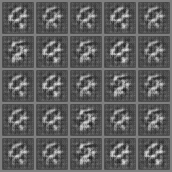

epoch: 1/100, batch: 810/1200, G_loss: -87.86665344238281, D_loss: (-90.61560821533203, 27.631019592285156)
epoch: 1/100, batch: 820/1200, G_loss: -112.18194580078125, D_loss: (-111.8915023803711, 27.631019592285156)
epoch: 1/100, batch: 830/1200, G_loss: -94.49809265136719, D_loss: (-97.6590805053711, 27.631019592285156)
epoch: 1/100, batch: 840/1200, G_loss: -96.70857238769531, D_loss: (-98.59412384033203, 27.631019592285156)
epoch: 1/100, batch: 850/1200, G_loss: -111.62932586669922, D_loss: (-112.73452758789062, 27.631019592285156)


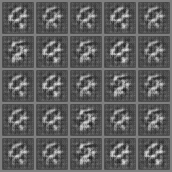

epoch: 1/100, batch: 860/1200, G_loss: -90.62974548339844, D_loss: (-93.44757843017578, 27.631019592285156)
epoch: 1/100, batch: 870/1200, G_loss: -88.97189331054688, D_loss: (-92.6732406616211, 27.631019592285156)
epoch: 1/100, batch: 880/1200, G_loss: -78.47209930419922, D_loss: (-79.96900177001953, 27.631019592285156)
epoch: 1/100, batch: 890/1200, G_loss: -116.05028533935547, D_loss: (-117.15550994873047, 27.631019592285156)
epoch: 1/100, batch: 900/1200, G_loss: -90.62974548339844, D_loss: (-91.43843841552734, 27.631019592285156)


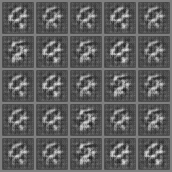

epoch: 1/100, batch: 910/1200, G_loss: -106.6557388305664, D_loss: (-106.52204895019531, 27.631019592285156)
epoch: 1/100, batch: 920/1200, G_loss: -83.44568634033203, D_loss: (-86.00146484375, 27.631019592285156)
epoch: 1/100, batch: 930/1200, G_loss: -99.4716796875, D_loss: (-102.58702087402344, 27.631019592285156)
epoch: 1/100, batch: 940/1200, G_loss: -113.28718566894531, D_loss: (-115.36324310302734, 27.631019592285156)
epoch: 1/100, batch: 950/1200, G_loss: -83.99829864501953, D_loss: (-86.39844512939453, 27.631019592285156)


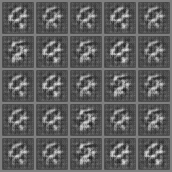

epoch: 1/100, batch: 960/1200, G_loss: -104.99787902832031, D_loss: (-104.42679595947266, 27.631019592285156)
epoch: 1/100, batch: 970/1200, G_loss: -74.603759765625, D_loss: (-77.40770721435547, 27.631019592285156)
epoch: 1/100, batch: 980/1200, G_loss: -100.5769271850586, D_loss: (-102.23477172851562, 27.631019592285156)
epoch: 1/100, batch: 990/1200, G_loss: -119.36600494384766, D_loss: (-121.01869201660156, 27.631019592285156)
epoch: 1/100, batch: 1000/1200, G_loss: -91.73500061035156, D_loss: (-95.02758026123047, 27.631019592285156)


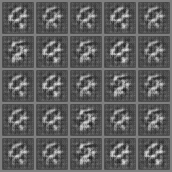

epoch: 1/100, batch: 1010/1200, G_loss: -87.86663818359375, D_loss: (-90.57115173339844, 27.631019592285156)
epoch: 1/100, batch: 1020/1200, G_loss: -93.94546508789062, D_loss: (-96.15594482421875, 27.631019592285156)
epoch: 1/100, batch: 1030/1200, G_loss: -86.20878601074219, D_loss: (-88.80928039550781, 27.631019592285156)
epoch: 1/100, batch: 1040/1200, G_loss: -106.6557388305664, D_loss: (-109.71570587158203, 27.631019592285156)
epoch: 1/100, batch: 1050/1200, G_loss: -95.05071258544922, D_loss: (-97.78543853759766, 27.631019592285156)


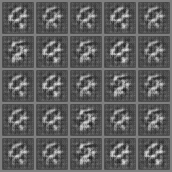

epoch: 1/100, batch: 1060/1200, G_loss: -104.99787902832031, D_loss: (-108.7538833618164, 27.631019592285156)
epoch: 1/100, batch: 1070/1200, G_loss: -96.15596008300781, D_loss: (-93.58659362792969, 27.631019592285156)
epoch: 1/100, batch: 1080/1200, G_loss: -74.603759765625, D_loss: (-79.90533447265625, 27.631019592285156)
epoch: 1/100, batch: 1090/1200, G_loss: -74.603759765625, D_loss: (-79.814697265625, 27.631019592285156)
epoch: 1/100, batch: 1100/1200, G_loss: -88.41926574707031, D_loss: (-91.10594940185547, 27.631019592285156)


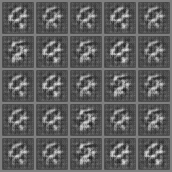

epoch: 1/100, batch: 1110/1200, G_loss: -83.99829864501953, D_loss: (-86.96064758300781, 27.631019592285156)
epoch: 1/100, batch: 1120/1200, G_loss: -101.1295394897461, D_loss: (-103.3378677368164, 27.631019592285156)
epoch: 1/100, batch: 1130/1200, G_loss: -90.0771255493164, D_loss: (-93.89473724365234, 27.631019592285156)
epoch: 1/100, batch: 1140/1200, G_loss: -86.20878601074219, D_loss: (-89.3251953125, 27.631019592285156)
epoch: 1/100, batch: 1150/1200, G_loss: -102.23478698730469, D_loss: (-102.4236831665039, 27.631019592285156)


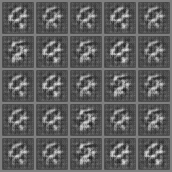

epoch: 1/100, batch: 1160/1200, G_loss: -97.81381225585938, D_loss: (-99.47142791748047, 27.631019592285156)
epoch: 1/100, batch: 1170/1200, G_loss: -77.36685180664062, D_loss: (-80.51414489746094, 27.631019592285156)
epoch: 1/100, batch: 1180/1200, G_loss: -82.89306640625, D_loss: (-84.53600311279297, 27.631019592285156)
epoch: 1/100, batch: 1190/1200, G_loss: -77.91947937011719, D_loss: (-80.53627014160156, 27.631019592285156)
epoch: 2/100, batch: 0/1200, G_loss: -106.1031265258789, D_loss: (-106.65573120117188, 27.631019592285156)


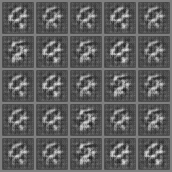

epoch: 2/100, batch: 10/1200, G_loss: -92.28760528564453, D_loss: (-96.15591430664062, 27.631019592285156)
epoch: 2/100, batch: 20/1200, G_loss: -83.9983139038086, D_loss: (-86.7612533569336, 27.631019592285156)
epoch: 2/100, batch: 30/1200, G_loss: -98.3664321899414, D_loss: (-101.09382629394531, 27.631019592285156)
epoch: 2/100, batch: 40/1200, G_loss: -90.62974548339844, D_loss: (-93.22025299072266, 27.631019592285156)
epoch: 2/100, batch: 50/1200, G_loss: -80.68258666992188, D_loss: (-84.71607208251953, 27.631019592285156)


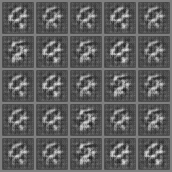

epoch: 2/100, batch: 60/1200, G_loss: -77.36685180664062, D_loss: (-79.34201049804688, 27.631019592285156)
epoch: 2/100, batch: 70/1200, G_loss: -93.94548034667969, D_loss: (-95.60059356689453, 27.631019592285156)
epoch: 2/100, batch: 80/1200, G_loss: -81.2352066040039, D_loss: (-85.03069305419922, 27.631019592285156)
epoch: 2/100, batch: 90/1200, G_loss: -87.31402587890625, D_loss: (-90.73200988769531, 27.631019592285156)
epoch: 2/100, batch: 100/1200, G_loss: -118.26078033447266, D_loss: (-119.91862487792969, 27.631019592285156)


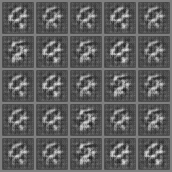

epoch: 2/100, batch: 110/1200, G_loss: -102.23477172851562, D_loss: (-104.19587707519531, 27.631019592285156)
epoch: 2/100, batch: 120/1200, G_loss: -112.73457336425781, D_loss: (-115.25534057617188, 27.631019592285156)
epoch: 2/100, batch: 130/1200, G_loss: -97.26119232177734, D_loss: (-100.02427673339844, 27.631019592285156)
epoch: 2/100, batch: 140/1200, G_loss: -102.23478698730469, D_loss: (-102.22074127197266, 27.631019592285156)
epoch: 2/100, batch: 150/1200, G_loss: -118.8133773803711, D_loss: (-119.25171661376953, 27.631019592285156)


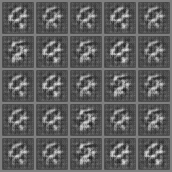

epoch: 2/100, batch: 160/1200, G_loss: -100.57691192626953, D_loss: (-102.23477172851562, 27.631019592285156)
epoch: 2/100, batch: 170/1200, G_loss: -96.70857238769531, D_loss: (-99.05526733398438, 27.631019592285156)
epoch: 2/100, batch: 180/1200, G_loss: -96.70857238769531, D_loss: (-99.07117462158203, 27.631019592285156)
epoch: 2/100, batch: 190/1200, G_loss: -93.94546508789062, D_loss: (-96.70835876464844, 27.631019592285156)
epoch: 2/100, batch: 200/1200, G_loss: -108.31360626220703, D_loss: (-109.65261840820312, 27.631019592285156)


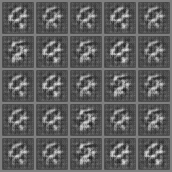

epoch: 2/100, batch: 210/1200, G_loss: -86.20878601074219, D_loss: (-88.29785919189453, 27.631019592285156)
epoch: 2/100, batch: 220/1200, G_loss: -117.70814514160156, D_loss: (-118.6889419555664, 27.631019592285156)
epoch: 2/100, batch: 230/1200, G_loss: -99.4716796875, D_loss: (-99.23790740966797, 27.631019592285156)
epoch: 2/100, batch: 240/1200, G_loss: -98.3664321899414, D_loss: (-101.10292053222656, 27.631019592285156)
epoch: 2/100, batch: 250/1200, G_loss: -89.52450561523438, D_loss: (-92.8402328491211, 27.631019592285156)


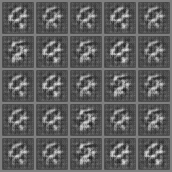

epoch: 2/100, batch: 260/1200, G_loss: -98.91905975341797, D_loss: (-100.5768814086914, 27.631019592285156)
epoch: 2/100, batch: 270/1200, G_loss: -82.89306640625, D_loss: (-87.28399658203125, 27.631019592285156)
epoch: 2/100, batch: 280/1200, G_loss: -98.91905975341797, D_loss: (-99.94091796875, 27.631019592285156)
epoch: 2/100, batch: 290/1200, G_loss: -90.0771255493164, D_loss: (-89.61564636230469, 27.631019592285156)
epoch: 2/100, batch: 300/1200, G_loss: -118.2607650756836, D_loss: (-119.88864135742188, 27.631019592285156)


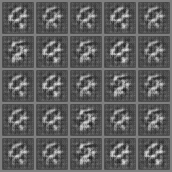

epoch: 2/100, batch: 310/1200, G_loss: -101.68215942382812, D_loss: (-103.89263916015625, 27.631019592285156)
epoch: 2/100, batch: 320/1200, G_loss: -106.1031265258789, D_loss: (-107.76097869873047, 27.631019592285156)
epoch: 2/100, batch: 330/1200, G_loss: -104.99787902832031, D_loss: (-106.68351745605469, 27.631019592285156)
epoch: 2/100, batch: 340/1200, G_loss: -100.57691192626953, D_loss: (-104.69841766357422, 27.631019592285156)
epoch: 2/100, batch: 350/1200, G_loss: -93.39285278320312, D_loss: (-95.60305786132812, 27.631019592285156)


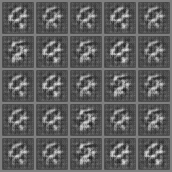

epoch: 2/100, batch: 360/1200, G_loss: -105.55050659179688, D_loss: (-107.46832275390625, 27.631019592285156)
epoch: 2/100, batch: 370/1200, G_loss: -99.47167205810547, D_loss: (-102.66747283935547, 27.631019592285156)
epoch: 2/100, batch: 380/1200, G_loss: -118.81338500976562, D_loss: (-121.0074691772461, 27.631019592285156)
epoch: 2/100, batch: 390/1200, G_loss: -96.70857238769531, D_loss: (-100.51065063476562, 27.631019592285156)
epoch: 2/100, batch: 400/1200, G_loss: -93.39285278320312, D_loss: (-95.01471710205078, 27.631019592285156)


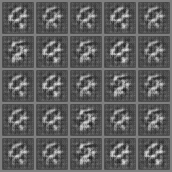

epoch: 2/100, batch: 410/1200, G_loss: -93.39285278320312, D_loss: (-96.37117004394531, 27.631019592285156)
epoch: 2/100, batch: 420/1200, G_loss: -91.18236541748047, D_loss: (-92.25062561035156, 27.631019592285156)
epoch: 2/100, batch: 430/1200, G_loss: -90.62974548339844, D_loss: (-94.95419311523438, 27.631019592285156)
epoch: 2/100, batch: 440/1200, G_loss: -100.02429962158203, D_loss: (-101.69985961914062, 27.631019592285156)
epoch: 2/100, batch: 450/1200, G_loss: -93.94546508789062, D_loss: (-96.05560302734375, 27.631019592285156)


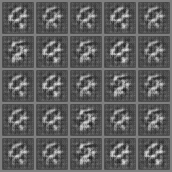

epoch: 2/100, batch: 460/1200, G_loss: -109.97146606445312, D_loss: (-112.17764282226562, 27.631019592285156)
epoch: 2/100, batch: 470/1200, G_loss: -110.52407836914062, D_loss: (-112.72677612304688, 27.631019592285156)
epoch: 2/100, batch: 480/1200, G_loss: -86.20878601074219, D_loss: (-90.37640380859375, 27.631019592285156)
epoch: 2/100, batch: 490/1200, G_loss: -95.60334014892578, D_loss: (-97.50269317626953, 27.631019592285156)
epoch: 2/100, batch: 500/1200, G_loss: -93.94546508789062, D_loss: (-95.87946319580078, 27.631019592285156)


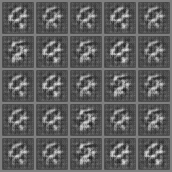

epoch: 2/100, batch: 510/1200, G_loss: -94.49808502197266, D_loss: (-96.67736053466797, 27.631019592285156)
epoch: 2/100, batch: 520/1200, G_loss: -112.18194580078125, D_loss: (-113.83970642089844, 27.631019592285156)
epoch: 2/100, batch: 530/1200, G_loss: -88.41926574707031, D_loss: (-88.97189331054688, 27.631019592285156)
epoch: 2/100, batch: 540/1200, G_loss: -109.97146606445312, D_loss: (-112.73450469970703, 27.631019592285156)
epoch: 2/100, batch: 550/1200, G_loss: -79.02471923828125, D_loss: (-82.31253051757812, 27.631019592285156)


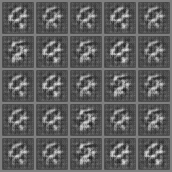

epoch: 2/100, batch: 560/1200, G_loss: -92.84022521972656, D_loss: (-94.377685546875, 27.631019592285156)
epoch: 2/100, batch: 570/1200, G_loss: -77.36685943603516, D_loss: (-79.28047180175781, 27.631019592285156)
epoch: 2/100, batch: 580/1200, G_loss: -96.15596008300781, D_loss: (-99.79556274414062, 27.631019592285156)
epoch: 2/100, batch: 590/1200, G_loss: -102.78739929199219, D_loss: (-104.1996841430664, 27.631019592285156)
epoch: 2/100, batch: 600/1200, G_loss: -88.97189331054688, D_loss: (-93.21099853515625, 27.631019592285156)


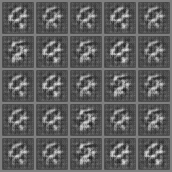

epoch: 2/100, batch: 610/1200, G_loss: -93.94546508789062, D_loss: (-95.12191772460938, 27.631019592285156)
epoch: 2/100, batch: 620/1200, G_loss: -90.0771255493164, D_loss: (-93.86345672607422, 27.631019592285156)
epoch: 2/100, batch: 630/1200, G_loss: -99.47167205810547, D_loss: (-102.5519790649414, 27.631019592285156)
epoch: 2/100, batch: 640/1200, G_loss: -90.62974548339844, D_loss: (-93.67265319824219, 27.631019592285156)
epoch: 2/100, batch: 650/1200, G_loss: -98.91905212402344, D_loss: (-100.83191680908203, 27.631019592285156)


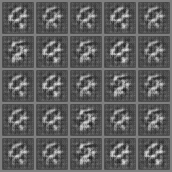

epoch: 2/100, batch: 660/1200, G_loss: -97.81381225585938, D_loss: (-100.48465728759766, 27.631019592285156)
epoch: 2/100, batch: 670/1200, G_loss: -103.34001922607422, D_loss: (-104.44525146484375, 27.631019592285156)
epoch: 2/100, batch: 680/1200, G_loss: -110.52407836914062, D_loss: (-111.26742553710938, 27.631019592285156)
epoch: 2/100, batch: 690/1200, G_loss: -97.8138198852539, D_loss: (-100.55004119873047, 27.631019592285156)
epoch: 2/100, batch: 700/1200, G_loss: -95.05070495605469, D_loss: (-97.81378173828125, 27.631019592285156)


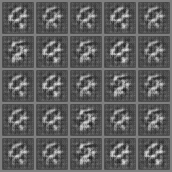

epoch: 2/100, batch: 710/1200, G_loss: -104.99787902832031, D_loss: (-107.07408905029297, 27.631019592285156)
epoch: 2/100, batch: 720/1200, G_loss: -107.20835876464844, D_loss: (-106.67720031738281, 27.631019592285156)
epoch: 2/100, batch: 730/1200, G_loss: -85.10354614257812, D_loss: (-84.9706039428711, 27.631019592285156)
epoch: 2/100, batch: 740/1200, G_loss: -87.86665344238281, D_loss: (-90.07711029052734, 27.631019592285156)
epoch: 2/100, batch: 750/1200, G_loss: -106.6557388305664, D_loss: (-108.55919647216797, 27.631019592285156)


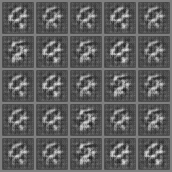

epoch: 2/100, batch: 760/1200, G_loss: -89.5245132446289, D_loss: (-94.36540985107422, 27.631019592285156)
epoch: 2/100, batch: 770/1200, G_loss: -92.8402328491211, D_loss: (-94.08094024658203, 27.631019592285156)
epoch: 2/100, batch: 780/1200, G_loss: -81.7878189086914, D_loss: (-85.87548828125, 27.631019592285156)
epoch: 2/100, batch: 790/1200, G_loss: -104.44526672363281, D_loss: (-107.06523132324219, 27.631019592285156)
epoch: 2/100, batch: 800/1200, G_loss: -109.97146606445312, D_loss: (-108.11410522460938, 27.631019592285156)


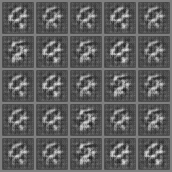

epoch: 2/100, batch: 810/1200, G_loss: -82.34043884277344, D_loss: (-87.21424865722656, 27.631019592285156)
epoch: 2/100, batch: 820/1200, G_loss: -97.26119232177734, D_loss: (-98.91584014892578, 27.631019592285156)
epoch: 2/100, batch: 830/1200, G_loss: -95.60334014892578, D_loss: (-95.58049011230469, 27.631019592285156)
epoch: 2/100, batch: 840/1200, G_loss: -104.44525146484375, D_loss: (-103.47848510742188, 27.631019592285156)
epoch: 2/100, batch: 850/1200, G_loss: -96.15596008300781, D_loss: (-98.36593627929688, 27.631019592285156)


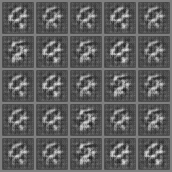

epoch: 2/100, batch: 860/1200, G_loss: -87.86665344238281, D_loss: (-89.46205139160156, 27.631019592285156)
epoch: 2/100, batch: 870/1200, G_loss: -92.8402328491211, D_loss: (-95.88955688476562, 27.631019592285156)
epoch: 2/100, batch: 880/1200, G_loss: -71.84065246582031, D_loss: (-74.64750671386719, 27.631019592285156)
epoch: 2/100, batch: 890/1200, G_loss: -108.86621856689453, D_loss: (-111.41590118408203, 27.631019592285156)
epoch: 2/100, batch: 900/1200, G_loss: -106.1031265258789, D_loss: (-106.16521453857422, 27.631019592285156)


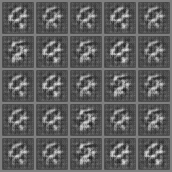

epoch: 2/100, batch: 910/1200, G_loss: -96.15596008300781, D_loss: (-98.9190444946289, 27.631019592285156)
epoch: 2/100, batch: 920/1200, G_loss: -91.18236541748047, D_loss: (-91.53882598876953, 27.631019592285156)
epoch: 2/100, batch: 930/1200, G_loss: -82.89306640625, D_loss: (-85.10354614257812, 27.631019592285156)
epoch: 2/100, batch: 940/1200, G_loss: -87.31403350830078, D_loss: (-92.1359634399414, 27.631019592285156)
epoch: 2/100, batch: 950/1200, G_loss: -113.28718566894531, D_loss: (-116.60289001464844, 27.631019592285156)


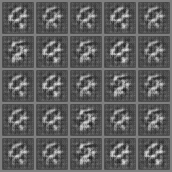

epoch: 2/100, batch: 960/1200, G_loss: -106.6557388305664, D_loss: (-108.86621856689453, 27.631019592285156)
epoch: 2/100, batch: 970/1200, G_loss: -97.81381225585938, D_loss: (-101.07506561279297, 27.631019592285156)
epoch: 2/100, batch: 980/1200, G_loss: -98.3664321899414, D_loss: (-100.43281555175781, 27.631019592285156)
epoch: 2/100, batch: 990/1200, G_loss: -78.47209930419922, D_loss: (-81.12110137939453, 27.631019592285156)
epoch: 2/100, batch: 1000/1200, G_loss: -84.55091857910156, D_loss: (-86.69464874267578, 27.631019592285156)


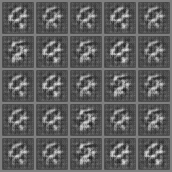

epoch: 2/100, batch: 1010/1200, G_loss: -93.39285278320312, D_loss: (-96.11882781982422, 27.631019592285156)
epoch: 2/100, batch: 1020/1200, G_loss: -90.62974548339844, D_loss: (-92.83181762695312, 27.631019592285156)
epoch: 2/100, batch: 1030/1200, G_loss: -59.1303825378418, D_loss: (-65.65542602539062, 27.631019592285156)
epoch: 2/100, batch: 1040/1200, G_loss: -83.99829864501953, D_loss: (-85.65614318847656, 27.631019592285156)
epoch: 2/100, batch: 1050/1200, G_loss: -100.57691192626953, D_loss: (-102.47984313964844, 27.631019592285156)


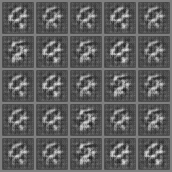

epoch: 2/100, batch: 1060/1200, G_loss: -93.39285278320312, D_loss: (-97.2601089477539, 27.631019592285156)
epoch: 2/100, batch: 1070/1200, G_loss: -87.31402587890625, D_loss: (-91.5924301147461, 27.631019592285156)
epoch: 2/100, batch: 1080/1200, G_loss: -103.34001922607422, D_loss: (-103.26443481445312, 27.631019592285156)
epoch: 2/100, batch: 1090/1200, G_loss: -103.89263916015625, D_loss: (-107.1655502319336, 27.631019592285156)
epoch: 2/100, batch: 1100/1200, G_loss: -79.57734680175781, D_loss: (-82.8917007446289, 27.631019592285156)


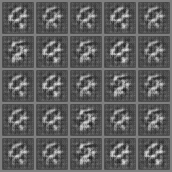

epoch: 2/100, batch: 1110/1200, G_loss: -121.57649230957031, D_loss: (-122.6817398071289, 27.631019592285156)
epoch: 2/100, batch: 1120/1200, G_loss: -112.18194580078125, D_loss: (-114.39136505126953, 27.631019592285156)
epoch: 2/100, batch: 1130/1200, G_loss: -108.86621856689453, D_loss: (-112.68302917480469, 27.631019592285156)
epoch: 2/100, batch: 1140/1200, G_loss: -101.12953186035156, D_loss: (-101.68215942382812, 27.631019592285156)
epoch: 2/100, batch: 1150/1200, G_loss: -82.89306640625, D_loss: (-85.87435913085938, 27.631019592285156)


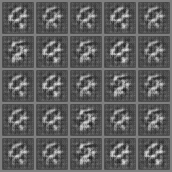

epoch: 2/100, batch: 1160/1200, G_loss: -91.182373046875, D_loss: (-94.54945373535156, 27.631019592285156)
epoch: 2/100, batch: 1170/1200, G_loss: -77.36685943603516, D_loss: (-77.52546691894531, 27.631019592285156)
epoch: 2/100, batch: 1180/1200, G_loss: -81.2352066040039, D_loss: (-83.49364471435547, 27.631019592285156)
epoch: 2/100, batch: 1190/1200, G_loss: -92.8402328491211, D_loss: (-96.1552505493164, 27.631019592285156)
epoch: 3/100, batch: 0/1200, G_loss: -103.34001922607422, D_loss: (-105.46558380126953, 27.631019592285156)


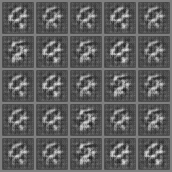

epoch: 3/100, batch: 10/1200, G_loss: -86.20878601074219, D_loss: (-91.17855834960938, 27.631019592285156)
epoch: 3/100, batch: 20/1200, G_loss: -81.2352066040039, D_loss: (-81.63477325439453, 27.631019592285156)
epoch: 3/100, batch: 30/1200, G_loss: -85.65617370605469, D_loss: (-87.45646667480469, 27.631019592285156)
epoch: 3/100, batch: 40/1200, G_loss: -92.2876205444336, D_loss: (-95.6023178100586, 27.631019592285156)
epoch: 3/100, batch: 50/1200, G_loss: -79.57733917236328, D_loss: (-83.28582000732422, 27.631019592285156)


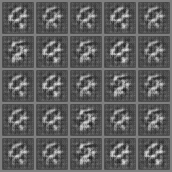

epoch: 3/100, batch: 60/1200, G_loss: -106.1031265258789, D_loss: (-108.31359100341797, 27.631019592285156)
epoch: 3/100, batch: 70/1200, G_loss: -90.0771255493164, D_loss: (-91.18236541748047, 27.631019592285156)
epoch: 3/100, batch: 80/1200, G_loss: -114.3924331665039, D_loss: (-116.05029296875, 27.631019592285156)
epoch: 3/100, batch: 90/1200, G_loss: -86.20878601074219, D_loss: (-88.41925048828125, 27.631019592285156)
epoch: 3/100, batch: 100/1200, G_loss: -95.05072021484375, D_loss: (-96.70686340332031, 27.631019592285156)


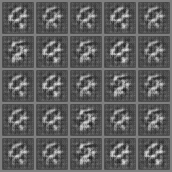

epoch: 3/100, batch: 110/1200, G_loss: -109.97146606445312, D_loss: (-112.05970764160156, 27.631019592285156)
epoch: 3/100, batch: 120/1200, G_loss: -96.15596008300781, D_loss: (-98.61367797851562, 27.631019592285156)
epoch: 3/100, batch: 130/1200, G_loss: -111.62932586669922, D_loss: (-112.18195343017578, 27.631019592285156)
epoch: 3/100, batch: 140/1200, G_loss: -89.5245132446289, D_loss: (-93.79765319824219, 27.631019592285156)
epoch: 3/100, batch: 150/1200, G_loss: -91.73499298095703, D_loss: (-95.59904479980469, 27.631019592285156)


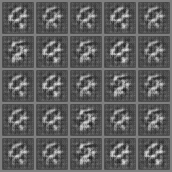

epoch: 3/100, batch: 160/1200, G_loss: -85.65615844726562, D_loss: (-89.52450561523438, 27.631019592285156)
epoch: 3/100, batch: 170/1200, G_loss: -88.41926574707031, D_loss: (-90.87286376953125, 27.631019592285156)
epoch: 3/100, batch: 180/1200, G_loss: -97.81381225585938, D_loss: (-99.95447540283203, 27.631019592285156)
epoch: 3/100, batch: 190/1200, G_loss: -101.1295394897461, D_loss: (-103.86285400390625, 27.631019592285156)
epoch: 3/100, batch: 200/1200, G_loss: -101.68215942382812, D_loss: (-104.29637908935547, 27.631019592285156)


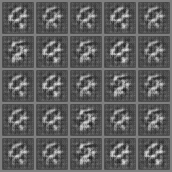

epoch: 3/100, batch: 210/1200, G_loss: -104.99787139892578, D_loss: (-106.56277465820312, 27.631019592285156)
epoch: 3/100, batch: 220/1200, G_loss: -65.76182556152344, D_loss: (-71.18598175048828, 27.631019592285156)
epoch: 3/100, batch: 230/1200, G_loss: -107.20835876464844, D_loss: (-108.71508026123047, 27.631019592285156)
epoch: 3/100, batch: 240/1200, G_loss: -91.18236541748047, D_loss: (-95.04524230957031, 27.631019592285156)
epoch: 3/100, batch: 250/1200, G_loss: -101.68215942382812, D_loss: (-105.54959106445312, 27.631019592285156)


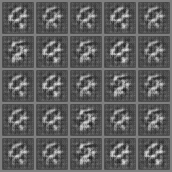

epoch: 3/100, batch: 260/1200, G_loss: -91.182373046875, D_loss: (-96.70356750488281, 27.631019592285156)
epoch: 3/100, batch: 270/1200, G_loss: -83.99829864501953, D_loss: (-84.5509262084961, 27.631019592285156)
epoch: 3/100, batch: 280/1200, G_loss: -102.23477172851562, D_loss: (-103.89263916015625, 27.631019592285156)
epoch: 3/100, batch: 290/1200, G_loss: -86.20878601074219, D_loss: (-85.98422241210938, 27.631019592285156)
epoch: 3/100, batch: 300/1200, G_loss: -86.76140594482422, D_loss: (-89.81041717529297, 27.631019592285156)


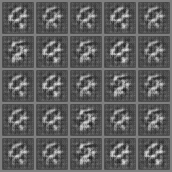

epoch: 3/100, batch: 310/1200, G_loss: -83.99829864501953, D_loss: (-87.26237487792969, 27.631019592285156)
epoch: 3/100, batch: 320/1200, G_loss: -95.05071258544922, D_loss: (-98.34713745117188, 27.631019592285156)
epoch: 3/100, batch: 330/1200, G_loss: -104.99787902832031, D_loss: (-106.62824249267578, 27.631019592285156)
epoch: 3/100, batch: 340/1200, G_loss: -111.07670593261719, D_loss: (-112.96732330322266, 27.631019592285156)
epoch: 3/100, batch: 350/1200, G_loss: -71.28802490234375, D_loss: (-75.06983184814453, 27.631019592285156)


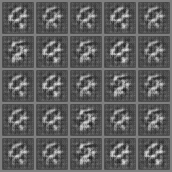

epoch: 3/100, batch: 360/1200, G_loss: -92.8402328491211, D_loss: (-96.15594482421875, 27.631019592285156)
epoch: 3/100, batch: 370/1200, G_loss: -104.99787902832031, D_loss: (-106.1031265258789, 27.631019592285156)
epoch: 3/100, batch: 380/1200, G_loss: -75.70899963378906, D_loss: (-77.91936492919922, 27.631019592285156)
epoch: 3/100, batch: 390/1200, G_loss: -79.02471923828125, D_loss: (-83.23471069335938, 27.631019592285156)
epoch: 3/100, batch: 400/1200, G_loss: -118.81340026855469, D_loss: (-119.91862487792969, 27.631019592285156)


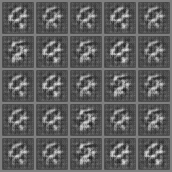

epoch: 3/100, batch: 410/1200, G_loss: -89.5245132446289, D_loss: (-92.96678924560547, 27.631019592285156)
epoch: 3/100, batch: 420/1200, G_loss: -109.97146606445312, D_loss: (-111.07670593261719, 27.631019592285156)
epoch: 3/100, batch: 430/1200, G_loss: -104.44525146484375, D_loss: (-105.55049133300781, 27.631019592285156)
epoch: 3/100, batch: 440/1200, G_loss: -111.07670593261719, D_loss: (-114.39242553710938, 27.631019592285156)
epoch: 3/100, batch: 450/1200, G_loss: -114.9450454711914, D_loss: (-114.9450454711914, 27.631019592285156)


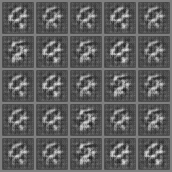

epoch: 3/100, batch: 460/1200, G_loss: -72.94589233398438, D_loss: (-75.70216369628906, 27.631019592285156)
epoch: 3/100, batch: 470/1200, G_loss: -123.2343521118164, D_loss: (-124.559326171875, 27.631019592285156)
epoch: 3/100, batch: 480/1200, G_loss: -113.83980560302734, D_loss: (-114.9443130493164, 27.631019592285156)
epoch: 3/100, batch: 490/1200, G_loss: -87.86665344238281, D_loss: (-91.73249053955078, 27.631019592285156)
epoch: 3/100, batch: 500/1200, G_loss: -90.0771255493164, D_loss: (-92.84005737304688, 27.631019592285156)


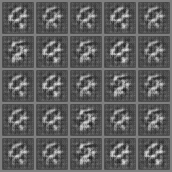

epoch: 3/100, batch: 510/1200, G_loss: -94.49809265136719, D_loss: (-97.88184356689453, 27.631019592285156)
epoch: 3/100, batch: 520/1200, G_loss: -88.41926574707031, D_loss: (-87.7444839477539, 27.631019592285156)
epoch: 3/100, batch: 530/1200, G_loss: -82.34044647216797, D_loss: (-87.86642456054688, 27.631019592285156)
epoch: 3/100, batch: 540/1200, G_loss: -81.7878189086914, D_loss: (-85.1035385131836, 27.631019592285156)
epoch: 3/100, batch: 550/1200, G_loss: -89.5245132446289, D_loss: (-93.93531036376953, 27.631019592285156)


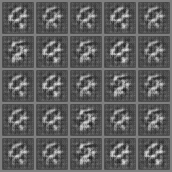

epoch: 3/100, batch: 560/1200, G_loss: -79.02471923828125, D_loss: (-81.78032684326172, 27.631019592285156)
epoch: 3/100, batch: 570/1200, G_loss: -96.15596008300781, D_loss: (-96.70857238769531, 27.631019592285156)
epoch: 3/100, batch: 580/1200, G_loss: -103.34001922607422, D_loss: (-104.44523620605469, 27.631019592285156)
epoch: 3/100, batch: 590/1200, G_loss: -93.39285278320312, D_loss: (-98.18718719482422, 27.631019592285156)
epoch: 3/100, batch: 600/1200, G_loss: -111.62932586669922, D_loss: (-112.72586059570312, 27.631019592285156)


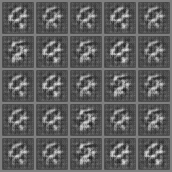

epoch: 3/100, batch: 610/1200, G_loss: -102.78739929199219, D_loss: (-103.1673812866211, 27.631019592285156)
epoch: 3/100, batch: 620/1200, G_loss: -108.31360626220703, D_loss: (-111.39923858642578, 27.631019592285156)
epoch: 3/100, batch: 630/1200, G_loss: -91.18236541748047, D_loss: (-93.3927993774414, 27.631019592285156)
epoch: 3/100, batch: 640/1200, G_loss: -87.31402587890625, D_loss: (-91.55555725097656, 27.631019592285156)
epoch: 3/100, batch: 650/1200, G_loss: -95.05071258544922, D_loss: (-98.2419204711914, 27.631019592285156)


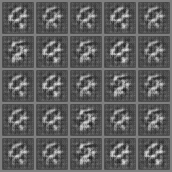

epoch: 3/100, batch: 660/1200, G_loss: -94.49808502197266, D_loss: (-97.22017669677734, 27.631019592285156)
epoch: 3/100, batch: 670/1200, G_loss: -106.1031265258789, D_loss: (-107.76097869873047, 27.631019592285156)
epoch: 3/100, batch: 680/1200, G_loss: -88.97188568115234, D_loss: (-91.72134399414062, 27.631019592285156)
epoch: 3/100, batch: 690/1200, G_loss: -92.28760528564453, D_loss: (-94.1983871459961, 27.631019592285156)
epoch: 3/100, batch: 700/1200, G_loss: -98.91905975341797, D_loss: (-100.56734466552734, 27.631019592285156)


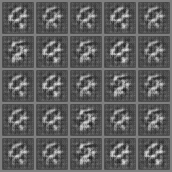

epoch: 3/100, batch: 710/1200, G_loss: -88.41926574707031, D_loss: (-92.51363372802734, 27.631019592285156)
epoch: 3/100, batch: 720/1200, G_loss: -110.52407836914062, D_loss: (-113.83332061767578, 27.631019592285156)
epoch: 3/100, batch: 730/1200, G_loss: -81.2352066040039, D_loss: (-83.4453125, 27.631019592285156)
epoch: 3/100, batch: 740/1200, G_loss: -86.76140594482422, D_loss: (-89.36388397216797, 27.631019592285156)
epoch: 3/100, batch: 750/1200, G_loss: -96.15596008300781, D_loss: (-101.1259536743164, 27.631019592285156)


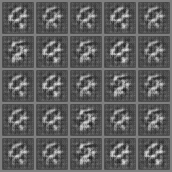

epoch: 3/100, batch: 760/1200, G_loss: -102.78739166259766, D_loss: (-107.20834350585938, 27.631019592285156)
epoch: 3/100, batch: 770/1200, G_loss: -76.81423950195312, D_loss: (-79.46424102783203, 27.631019592285156)
epoch: 3/100, batch: 780/1200, G_loss: -113.28718566894531, D_loss: (-114.94503784179688, 27.631019592285156)
epoch: 3/100, batch: 790/1200, G_loss: -87.31402587890625, D_loss: (-90.07550048828125, 27.631019592285156)
epoch: 3/100, batch: 800/1200, G_loss: -92.84022521972656, D_loss: (-96.67403411865234, 27.631019592285156)


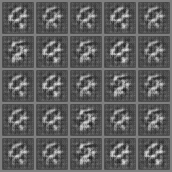

epoch: 3/100, batch: 810/1200, G_loss: -100.5769271850586, D_loss: (-102.64237213134766, 27.631019592285156)
epoch: 3/100, batch: 820/1200, G_loss: -91.18236541748047, D_loss: (-93.91545867919922, 27.631019592285156)
epoch: 3/100, batch: 830/1200, G_loss: -85.65615844726562, D_loss: (-88.86931610107422, 27.631019592285156)
epoch: 3/100, batch: 840/1200, G_loss: -90.62974548339844, D_loss: (-93.39285278320312, 27.631019592285156)
epoch: 3/100, batch: 850/1200, G_loss: -95.05071258544922, D_loss: (-96.15303039550781, 27.631019592285156)


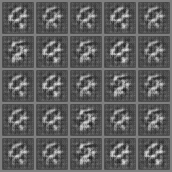

epoch: 3/100, batch: 860/1200, G_loss: -96.70857238769531, D_loss: (-101.11711883544922, 27.631019592285156)
epoch: 3/100, batch: 870/1200, G_loss: -97.81381225585938, D_loss: (-100.01799011230469, 27.631019592285156)
epoch: 3/100, batch: 880/1200, G_loss: -89.5245132446289, D_loss: (-92.78047180175781, 27.631019592285156)
epoch: 3/100, batch: 890/1200, G_loss: -106.6557388305664, D_loss: (-110.4720687866211, 27.631019592285156)
epoch: 3/100, batch: 900/1200, G_loss: -101.68215942382812, D_loss: (-103.89263916015625, 27.631019592285156)


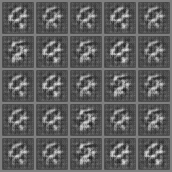

epoch: 3/100, batch: 910/1200, G_loss: -80.12995910644531, D_loss: (-81.78775024414062, 27.631019592285156)
epoch: 3/100, batch: 920/1200, G_loss: -76.2616195678711, D_loss: (-78.47209930419922, 27.631019592285156)
epoch: 3/100, batch: 930/1200, G_loss: -87.86663818359375, D_loss: (-91.17808532714844, 27.631019592285156)
epoch: 3/100, batch: 940/1200, G_loss: -79.57734680175781, D_loss: (-81.23519897460938, 27.631019592285156)
epoch: 3/100, batch: 950/1200, G_loss: -92.8402328491211, D_loss: (-93.39285278320312, 27.631019592285156)


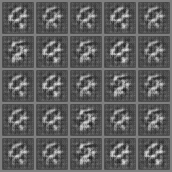

epoch: 3/100, batch: 960/1200, G_loss: -104.44525146484375, D_loss: (-107.06794738769531, 27.631019592285156)
epoch: 3/100, batch: 970/1200, G_loss: -104.44526672363281, D_loss: (-106.6557388305664, 27.631019592285156)
epoch: 3/100, batch: 980/1200, G_loss: -81.7878189086914, D_loss: (-85.0981674194336, 27.631019592285156)
epoch: 3/100, batch: 990/1200, G_loss: -91.182373046875, D_loss: (-93.83834838867188, 27.631019592285156)
epoch: 3/100, batch: 1000/1200, G_loss: -95.60333251953125, D_loss: (-96.70857238769531, 27.631019592285156)


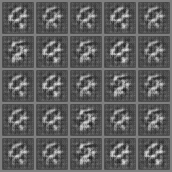

epoch: 3/100, batch: 1010/1200, G_loss: -116.05028533935547, D_loss: (-116.47055053710938, 27.631019592285156)
epoch: 3/100, batch: 1020/1200, G_loss: -106.1031265258789, D_loss: (-107.20769500732422, 27.631019592285156)
epoch: 3/100, batch: 1030/1200, G_loss: -87.86663818359375, D_loss: (-88.41926574707031, 27.631019592285156)
epoch: 3/100, batch: 1040/1200, G_loss: -87.31403350830078, D_loss: (-89.52438354492188, 27.631019592285156)
epoch: 3/100, batch: 1050/1200, G_loss: -78.47209930419922, D_loss: (-80.1298599243164, 27.631019592285156)


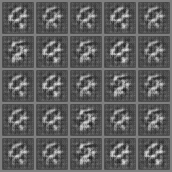

epoch: 3/100, batch: 1060/1200, G_loss: -76.81423950195312, D_loss: (-80.25122833251953, 27.631019592285156)
epoch: 3/100, batch: 1070/1200, G_loss: -102.78739929199219, D_loss: (-106.1031265258789, 27.631019592285156)
epoch: 3/100, batch: 1080/1200, G_loss: -93.39285278320312, D_loss: (-96.70825958251953, 27.631019592285156)
epoch: 3/100, batch: 1090/1200, G_loss: -98.91905975341797, D_loss: (-101.12953186035156, 27.631019592285156)
epoch: 3/100, batch: 1100/1200, G_loss: -88.41926574707031, D_loss: (-90.32853698730469, 27.631019592285156)


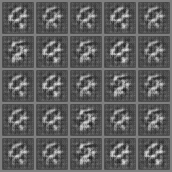

epoch: 3/100, batch: 1110/1200, G_loss: -99.4716796875, D_loss: (-102.78335571289062, 27.631019592285156)
epoch: 3/100, batch: 1120/1200, G_loss: -98.91905212402344, D_loss: (-101.68215942382812, 27.631019592285156)
epoch: 3/100, batch: 1130/1200, G_loss: -84.5509262084961, D_loss: (-88.41883850097656, 27.631019592285156)
epoch: 3/100, batch: 1140/1200, G_loss: -110.52407836914062, D_loss: (-111.62932586669922, 27.631019592285156)
epoch: 3/100, batch: 1150/1200, G_loss: -82.34044647216797, D_loss: (-86.76140594482422, 27.631019592285156)


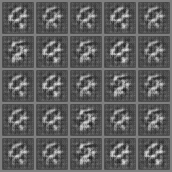

epoch: 3/100, batch: 1160/1200, G_loss: -97.81381225585938, D_loss: (-98.91905212402344, 27.631019592285156)
epoch: 3/100, batch: 1170/1200, G_loss: -87.86665344238281, D_loss: (-91.64044952392578, 27.631019592285156)
epoch: 3/100, batch: 1180/1200, G_loss: -83.99829864501953, D_loss: (-88.10964965820312, 27.631019592285156)
epoch: 3/100, batch: 1190/1200, G_loss: -100.02429962158203, D_loss: (-104.32089233398438, 27.631019592285156)
epoch: 4/100, batch: 0/1200, G_loss: -106.6557388305664, D_loss: (-108.8662338256836, 27.631019592285156)


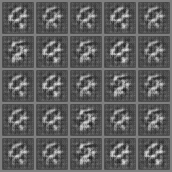

epoch: 4/100, batch: 10/1200, G_loss: -80.12995910644531, D_loss: (-82.05001068115234, 27.631019592285156)
epoch: 4/100, batch: 20/1200, G_loss: -119.91863250732422, D_loss: (-121.0238265991211, 27.631019592285156)
epoch: 4/100, batch: 30/1200, G_loss: -95.05071258544922, D_loss: (-97.6547622680664, 27.631019592285156)
epoch: 4/100, batch: 40/1200, G_loss: -88.41926574707031, D_loss: (-91.07054901123047, 27.631019592285156)
epoch: 4/100, batch: 50/1200, G_loss: -98.3664321899414, D_loss: (-101.67243194580078, 27.631019592285156)


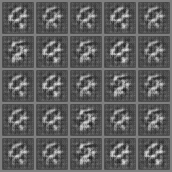

epoch: 4/100, batch: 60/1200, G_loss: -96.15596008300781, D_loss: (-98.91905212402344, 27.631019592285156)
epoch: 4/100, batch: 70/1200, G_loss: -91.73499298095703, D_loss: (-94.85521697998047, 27.631019592285156)
epoch: 4/100, batch: 80/1200, G_loss: -96.70857238769531, D_loss: (-98.6231918334961, 27.631019592285156)
epoch: 4/100, batch: 90/1200, G_loss: -111.07670593261719, D_loss: (-113.05304718017578, 27.631019592285156)
epoch: 4/100, batch: 100/1200, G_loss: -103.89263916015625, D_loss: (-104.92886352539062, 27.631019592285156)


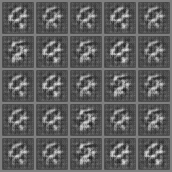

epoch: 4/100, batch: 110/1200, G_loss: -98.91905212402344, D_loss: (-101.0065689086914, 27.631019592285156)
epoch: 4/100, batch: 120/1200, G_loss: -96.70857238769531, D_loss: (-98.2874984741211, 27.631019592285156)
epoch: 4/100, batch: 130/1200, G_loss: -90.0771255493164, D_loss: (-92.28759002685547, 27.631019592285156)
epoch: 4/100, batch: 140/1200, G_loss: -82.89306640625, D_loss: (-87.15296936035156, 27.631019592285156)
epoch: 4/100, batch: 150/1200, G_loss: -111.62932586669922, D_loss: (-113.28718566894531, 27.631019592285156)


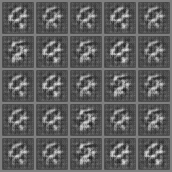

epoch: 4/100, batch: 160/1200, G_loss: -87.86665344238281, D_loss: (-91.25963592529297, 27.631019592285156)
epoch: 4/100, batch: 170/1200, G_loss: -85.65615844726562, D_loss: (-85.72351837158203, 27.631019592285156)
epoch: 4/100, batch: 180/1200, G_loss: -79.57733917236328, D_loss: (-83.3292007446289, 27.631019592285156)
epoch: 4/100, batch: 190/1200, G_loss: -98.3664321899414, D_loss: (-100.02429962158203, 27.631019592285156)
epoch: 4/100, batch: 200/1200, G_loss: -122.12911987304688, D_loss: (-125.44483184814453, 27.631019592285156)


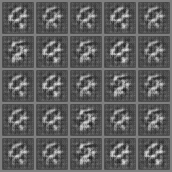

epoch: 4/100, batch: 210/1200, G_loss: -92.28760528564453, D_loss: (-95.33512878417969, 27.631019592285156)
epoch: 4/100, batch: 220/1200, G_loss: -95.60333251953125, D_loss: (-96.69470977783203, 27.631019592285156)
epoch: 4/100, batch: 230/1200, G_loss: -101.68215942382812, D_loss: (-103.89263916015625, 27.631019592285156)
epoch: 4/100, batch: 240/1200, G_loss: -94.49808502197266, D_loss: (-96.15594482421875, 27.631019592285156)
epoch: 4/100, batch: 250/1200, G_loss: -103.34001922607422, D_loss: (-107.71257019042969, 27.631019592285156)


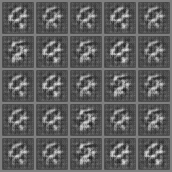

epoch: 4/100, batch: 260/1200, G_loss: -89.5245132446289, D_loss: (-91.72663879394531, 27.631019592285156)
epoch: 4/100, batch: 270/1200, G_loss: -92.84022521972656, D_loss: (-95.05070495605469, 27.631019592285156)
epoch: 4/100, batch: 280/1200, G_loss: -87.31402587890625, D_loss: (-90.06968688964844, 27.631019592285156)
epoch: 4/100, batch: 290/1200, G_loss: -113.28718566894531, D_loss: (-117.11601257324219, 27.631019592285156)
epoch: 4/100, batch: 300/1200, G_loss: -82.34044647216797, D_loss: (-85.62606811523438, 27.631019592285156)


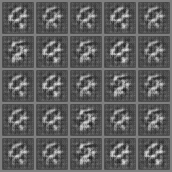

epoch: 4/100, batch: 310/1200, G_loss: -98.91905975341797, D_loss: (-102.22830200195312, 27.631019592285156)
epoch: 4/100, batch: 320/1200, G_loss: -102.78739929199219, D_loss: (-104.44500732421875, 27.631019592285156)
epoch: 4/100, batch: 330/1200, G_loss: -83.44568634033203, D_loss: (-85.65614318847656, 27.631019592285156)
epoch: 4/100, batch: 340/1200, G_loss: -96.15596008300781, D_loss: (-98.77288055419922, 27.631019592285156)
epoch: 4/100, batch: 350/1200, G_loss: -79.57733917236328, D_loss: (-82.8927230834961, 27.631019592285156)


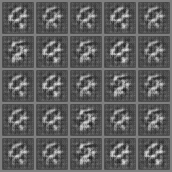

epoch: 4/100, batch: 360/1200, G_loss: -101.68215942382812, D_loss: (-104.99787902832031, 27.631019592285156)
epoch: 4/100, batch: 370/1200, G_loss: -86.76140594482422, D_loss: (-89.52450561523438, 27.631019592285156)
epoch: 4/100, batch: 380/1200, G_loss: -81.7878189086914, D_loss: (-84.28080749511719, 27.631019592285156)
epoch: 4/100, batch: 390/1200, G_loss: -90.0771255493164, D_loss: (-93.37953186035156, 27.631019592285156)
epoch: 4/100, batch: 400/1200, G_loss: -102.78739929199219, D_loss: (-105.5502700805664, 27.631019592285156)


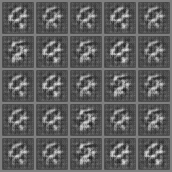

epoch: 4/100, batch: 410/1200, G_loss: -83.99829864501953, D_loss: (-86.76140594482422, 27.631019592285156)
epoch: 4/100, batch: 420/1200, G_loss: -98.3664321899414, D_loss: (-98.91905975341797, 27.631019592285156)
epoch: 4/100, batch: 430/1200, G_loss: -114.3924331665039, D_loss: (-116.04979705810547, 27.631019592285156)
epoch: 4/100, batch: 440/1200, G_loss: -93.39285278320312, D_loss: (-93.11052703857422, 27.631019592285156)
epoch: 4/100, batch: 450/1200, G_loss: -107.20835876464844, D_loss: (-109.97146606445312, 27.631019592285156)


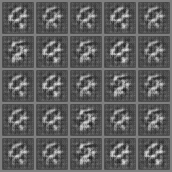

epoch: 4/100, batch: 460/1200, G_loss: -97.8138198852539, D_loss: (-100.50132751464844, 27.631019592285156)
epoch: 4/100, batch: 470/1200, G_loss: -93.39285278320312, D_loss: (-96.70857238769531, 27.631019592285156)
epoch: 4/100, batch: 480/1200, G_loss: -86.20878601074219, D_loss: (-89.51537322998047, 27.631019592285156)
epoch: 4/100, batch: 490/1200, G_loss: -77.36685180664062, D_loss: (-81.2352066040039, 27.631019592285156)
epoch: 4/100, batch: 500/1200, G_loss: -99.4716796875, D_loss: (-102.55693054199219, 27.631019592285156)


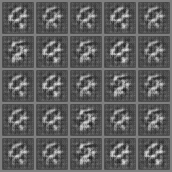

epoch: 4/100, batch: 510/1200, G_loss: -92.28760528564453, D_loss: (-93.39285278320312, 27.631019592285156)
epoch: 4/100, batch: 520/1200, G_loss: -127.10269165039062, D_loss: (-127.65533447265625, 27.631019592285156)
epoch: 4/100, batch: 530/1200, G_loss: -86.20878601074219, D_loss: (-87.31402587890625, 27.631019592285156)
epoch: 4/100, batch: 540/1200, G_loss: -83.99829864501953, D_loss: (-87.31402587890625, 27.631019592285156)
epoch: 4/100, batch: 550/1200, G_loss: -101.12953186035156, D_loss: (-102.78738403320312, 27.631019592285156)


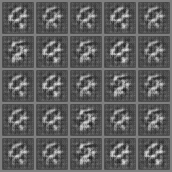

epoch: 4/100, batch: 560/1200, G_loss: -78.47209930419922, D_loss: (-82.62992095947266, 27.631019592285156)
epoch: 4/100, batch: 570/1200, G_loss: -106.1031265258789, D_loss: (-109.74987030029297, 27.631019592285156)
epoch: 4/100, batch: 580/1200, G_loss: -87.31403350830078, D_loss: (-89.5245132446289, 27.631019592285156)
epoch: 4/100, batch: 590/1200, G_loss: -81.2352066040039, D_loss: (-85.51988220214844, 27.631019592285156)
epoch: 4/100, batch: 600/1200, G_loss: -122.12911987304688, D_loss: (-122.38433837890625, 27.631019592285156)


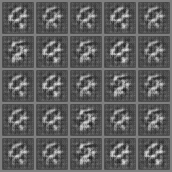

epoch: 4/100, batch: 610/1200, G_loss: -102.23477172851562, D_loss: (-105.24964904785156, 27.631019592285156)
epoch: 4/100, batch: 620/1200, G_loss: -91.182373046875, D_loss: (-95.05070495605469, 27.631019592285156)
epoch: 4/100, batch: 630/1200, G_loss: -96.70857238769531, D_loss: (-99.43526458740234, 27.631019592285156)
epoch: 4/100, batch: 640/1200, G_loss: -83.99829864501953, D_loss: (-88.41925811767578, 27.631019592285156)
epoch: 4/100, batch: 650/1200, G_loss: -97.81381225585938, D_loss: (-101.67927551269531, 27.631019592285156)


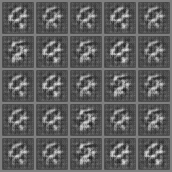

epoch: 4/100, batch: 660/1200, G_loss: -85.10354614257812, D_loss: (-87.8665542602539, 27.631019592285156)
epoch: 4/100, batch: 670/1200, G_loss: -91.73499298095703, D_loss: (-94.49777221679688, 27.631019592285156)
epoch: 4/100, batch: 680/1200, G_loss: -96.70857238769531, D_loss: (-98.91905212402344, 27.631019592285156)
epoch: 4/100, batch: 690/1200, G_loss: -90.62974548339844, D_loss: (-93.39251708984375, 27.631019592285156)
epoch: 4/100, batch: 700/1200, G_loss: -122.12911224365234, D_loss: (-124.89221954345703, 27.631019592285156)


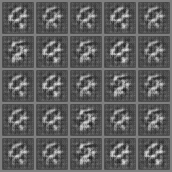

epoch: 4/100, batch: 710/1200, G_loss: -98.3664321899414, D_loss: (-99.47167205810547, 27.631019592285156)
epoch: 4/100, batch: 720/1200, G_loss: -100.02429962158203, D_loss: (-104.44525146484375, 27.631019592285156)
epoch: 4/100, batch: 730/1200, G_loss: -86.76140594482422, D_loss: (-93.28608703613281, 27.631019592285156)
epoch: 4/100, batch: 740/1200, G_loss: -86.76140594482422, D_loss: (-90.07711791992188, 27.631019592285156)
epoch: 4/100, batch: 750/1200, G_loss: -98.3664321899414, D_loss: (-102.16356658935547, 27.631019592285156)


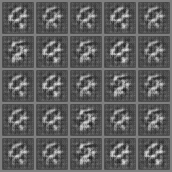

epoch: 4/100, batch: 760/1200, G_loss: -98.3664321899414, D_loss: (-100.57518768310547, 27.631019592285156)
epoch: 4/100, batch: 770/1200, G_loss: -100.02429962158203, D_loss: (-101.67115020751953, 27.631019592285156)
epoch: 4/100, batch: 780/1200, G_loss: -107.20835876464844, D_loss: (-109.4188461303711, 27.631019592285156)
epoch: 4/100, batch: 790/1200, G_loss: -103.34001922607422, D_loss: (-105.55024719238281, 27.631019592285156)
epoch: 4/100, batch: 800/1200, G_loss: -88.41925811767578, D_loss: (-90.42430877685547, 27.631019592285156)


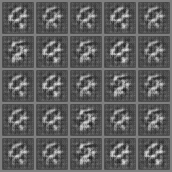

epoch: 4/100, batch: 810/1200, G_loss: -91.182373046875, D_loss: (-91.182373046875, 27.631019592285156)
epoch: 4/100, batch: 820/1200, G_loss: -102.23478698730469, D_loss: (-106.65568542480469, 27.631019592285156)
epoch: 4/100, batch: 830/1200, G_loss: -79.57733917236328, D_loss: (-84.55091857910156, 27.631019592285156)
epoch: 4/100, batch: 840/1200, G_loss: -91.18236541748047, D_loss: (-92.67420196533203, 27.631019592285156)
epoch: 4/100, batch: 850/1200, G_loss: -65.2092056274414, D_loss: (-70.72747802734375, 27.631019592285156)


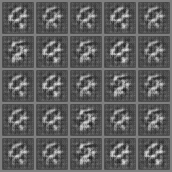

epoch: 4/100, batch: 860/1200, G_loss: -92.8402328491211, D_loss: (-94.97331237792969, 27.631019592285156)
epoch: 4/100, batch: 870/1200, G_loss: -102.78739166259766, D_loss: (-104.4154281616211, 27.631019592285156)
epoch: 4/100, batch: 880/1200, G_loss: -102.78739166259766, D_loss: (-104.79993438720703, 27.631019592285156)
epoch: 4/100, batch: 890/1200, G_loss: -94.49809265136719, D_loss: (-97.03277587890625, 27.631019592285156)
epoch: 4/100, batch: 900/1200, G_loss: -74.05113983154297, D_loss: (-78.40833282470703, 27.631019592285156)


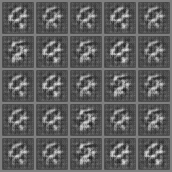

epoch: 4/100, batch: 910/1200, G_loss: -85.10354614257812, D_loss: (-87.86663818359375, 27.631019592285156)
epoch: 4/100, batch: 920/1200, G_loss: -83.99829864501953, D_loss: (-87.67310333251953, 27.631019592285156)
epoch: 4/100, batch: 930/1200, G_loss: -110.52407836914062, D_loss: (-111.56431579589844, 27.631019592285156)
epoch: 4/100, batch: 940/1200, G_loss: -104.99787902832031, D_loss: (-105.55049896240234, 27.631019592285156)
epoch: 4/100, batch: 950/1200, G_loss: -107.20835876464844, D_loss: (-108.8662338256836, 27.631019592285156)


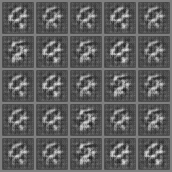

epoch: 4/100, batch: 960/1200, G_loss: -97.81381225585938, D_loss: (-101.6821060180664, 27.631019592285156)
epoch: 4/100, batch: 970/1200, G_loss: -115.49766540527344, D_loss: (-116.60289764404297, 27.631019592285156)
epoch: 4/100, batch: 980/1200, G_loss: -92.28760528564453, D_loss: (-93.94546508789062, 27.631019592285156)
epoch: 4/100, batch: 990/1200, G_loss: -108.31360626220703, D_loss: (-110.38298034667969, 27.631019592285156)
epoch: 4/100, batch: 1000/1200, G_loss: -84.5509262084961, D_loss: (-88.97129821777344, 27.631019592285156)


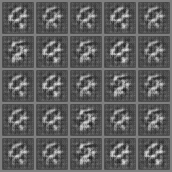

epoch: 4/100, batch: 1010/1200, G_loss: -83.44568634033203, D_loss: (-87.75634765625, 27.631019592285156)
epoch: 4/100, batch: 1020/1200, G_loss: -114.9450454711914, D_loss: (-117.60568237304688, 27.631019592285156)
epoch: 4/100, batch: 1030/1200, G_loss: -102.78739929199219, D_loss: (-105.55049896240234, 27.631019592285156)
epoch: 4/100, batch: 1040/1200, G_loss: -108.31360626220703, D_loss: (-110.52407836914062, 27.631019592285156)
epoch: 4/100, batch: 1050/1200, G_loss: -110.52407836914062, D_loss: (-110.52407836914062, 27.631019592285156)


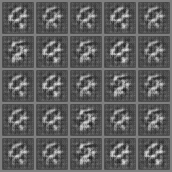

epoch: 4/100, batch: 1060/1200, G_loss: -99.4716796875, D_loss: (-101.6821517944336, 27.631019592285156)
epoch: 4/100, batch: 1070/1200, G_loss: -99.4716796875, D_loss: (-103.88058471679688, 27.631019592285156)
epoch: 4/100, batch: 1080/1200, G_loss: -108.8662338256836, D_loss: (-111.62928771972656, 27.631019592285156)
epoch: 4/100, batch: 1090/1200, G_loss: -96.15596008300781, D_loss: (-98.9190444946289, 27.631019592285156)
epoch: 4/100, batch: 1100/1200, G_loss: -104.99787902832031, D_loss: (-105.96244812011719, 27.631019592285156)


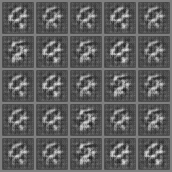

epoch: 4/100, batch: 1110/1200, G_loss: -114.9450454711914, D_loss: (-118.17460632324219, 27.631019592285156)
epoch: 4/100, batch: 1120/1200, G_loss: -101.12953186035156, D_loss: (-101.60972595214844, 27.631019592285156)
epoch: 4/100, batch: 1130/1200, G_loss: -101.68215942382812, D_loss: (-106.09009552001953, 27.631019592285156)
epoch: 4/100, batch: 1140/1200, G_loss: -92.8402328491211, D_loss: (-93.94546508789062, 27.631019592285156)
epoch: 4/100, batch: 1150/1200, G_loss: -91.182373046875, D_loss: (-95.56578826904297, 27.631019592285156)


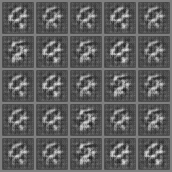

epoch: 4/100, batch: 1160/1200, G_loss: -104.99787902832031, D_loss: (-107.044921875, 27.631019592285156)
epoch: 4/100, batch: 1170/1200, G_loss: -81.7878189086914, D_loss: (-85.91290283203125, 27.631019592285156)
epoch: 4/100, batch: 1180/1200, G_loss: -97.8138198852539, D_loss: (-99.876708984375, 27.631019592285156)
epoch: 4/100, batch: 1190/1200, G_loss: -121.02386474609375, D_loss: (-121.57648468017578, 27.631019592285156)
epoch: 5/100, batch: 0/1200, G_loss: -109.4188461303711, D_loss: (-110.52407836914062, 27.631019592285156)


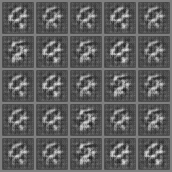

epoch: 5/100, batch: 10/1200, G_loss: -102.23478698730469, D_loss: (-104.90242004394531, 27.631019592285156)
epoch: 5/100, batch: 20/1200, G_loss: -103.34001922607422, D_loss: (-105.31672668457031, 27.631019592285156)
epoch: 5/100, batch: 30/1200, G_loss: -91.182373046875, D_loss: (-93.392822265625, 27.631019592285156)
epoch: 5/100, batch: 40/1200, G_loss: -101.1295394897461, D_loss: (-103.89263916015625, 27.631019592285156)
epoch: 5/100, batch: 50/1200, G_loss: -92.8402328491211, D_loss: (-94.90249633789062, 27.631019592285156)


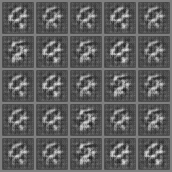

epoch: 5/100, batch: 60/1200, G_loss: -92.8402328491211, D_loss: (-96.70846557617188, 27.631019592285156)
epoch: 5/100, batch: 70/1200, G_loss: -62.446109771728516, D_loss: (-65.44971466064453, 27.631019592285156)
epoch: 5/100, batch: 80/1200, G_loss: -112.73457336425781, D_loss: (-113.28718566894531, 27.631019592285156)
epoch: 5/100, batch: 90/1200, G_loss: -94.49808502197266, D_loss: (-97.7870864868164, 27.631019592285156)
epoch: 5/100, batch: 100/1200, G_loss: -102.78739166259766, D_loss: (-103.34001922607422, 27.631019592285156)


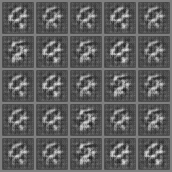

epoch: 5/100, batch: 110/1200, G_loss: -92.84022521972656, D_loss: (-96.06603240966797, 27.631019592285156)
epoch: 5/100, batch: 120/1200, G_loss: -100.57691192626953, D_loss: (-103.34001922607422, 27.631019592285156)
epoch: 5/100, batch: 130/1200, G_loss: -107.76097869873047, D_loss: (-107.6122817993164, 27.631019592285156)
epoch: 5/100, batch: 140/1200, G_loss: -80.68257904052734, D_loss: (-83.35567474365234, 27.631019592285156)
epoch: 5/100, batch: 150/1200, G_loss: -86.76140594482422, D_loss: (-89.5245132446289, 27.631019592285156)


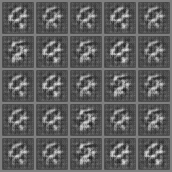

epoch: 5/100, batch: 160/1200, G_loss: -88.41926574707031, D_loss: (-92.00090026855469, 27.631019592285156)
epoch: 5/100, batch: 170/1200, G_loss: -97.81381225585938, D_loss: (-99.4716796875, 27.631019592285156)
epoch: 5/100, batch: 180/1200, G_loss: -90.62974548339844, D_loss: (-92.96361541748047, 27.631019592285156)
epoch: 5/100, batch: 190/1200, G_loss: -103.89263916015625, D_loss: (-104.99784851074219, 27.631019592285156)
epoch: 5/100, batch: 200/1200, G_loss: -81.23519897460938, D_loss: (-85.10350799560547, 27.631019592285156)


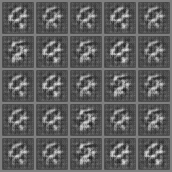

epoch: 5/100, batch: 210/1200, G_loss: -91.182373046875, D_loss: (-95.0506820678711, 27.631019592285156)
epoch: 5/100, batch: 220/1200, G_loss: -109.4188461303711, D_loss: (-111.07666015625, 27.631019592285156)
epoch: 5/100, batch: 230/1200, G_loss: -88.97189331054688, D_loss: (-92.28759765625, 27.631019592285156)
epoch: 5/100, batch: 240/1200, G_loss: -92.2876205444336, D_loss: (-93.94546508789062, 27.631019592285156)
epoch: 5/100, batch: 250/1200, G_loss: -82.89306640625, D_loss: (-86.1698226928711, 27.631019592285156)


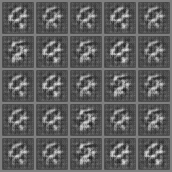

epoch: 5/100, batch: 260/1200, G_loss: -100.02429962158203, D_loss: (-102.17172241210938, 27.631019592285156)
epoch: 5/100, batch: 270/1200, G_loss: -88.97189331054688, D_loss: (-92.8402328491211, 27.631019592285156)
epoch: 5/100, batch: 280/1200, G_loss: -88.97189331054688, D_loss: (-92.84005737304688, 27.631019592285156)
epoch: 5/100, batch: 290/1200, G_loss: -118.81340026855469, D_loss: (-121.02044677734375, 27.631019592285156)
epoch: 5/100, batch: 300/1200, G_loss: -107.76097869873047, D_loss: (-111.07669830322266, 27.631019592285156)


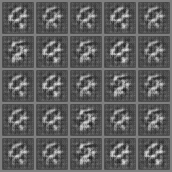

epoch: 5/100, batch: 310/1200, G_loss: -76.2616195678711, D_loss: (-79.45622253417969, 27.631019592285156)
epoch: 5/100, batch: 320/1200, G_loss: -94.49808502197266, D_loss: (-98.25907897949219, 27.631019592285156)
epoch: 5/100, batch: 330/1200, G_loss: -100.02429962158203, D_loss: (-101.67570495605469, 27.631019592285156)
epoch: 5/100, batch: 340/1200, G_loss: -87.86665344238281, D_loss: (-91.73499298095703, 27.631019592285156)
epoch: 5/100, batch: 350/1200, G_loss: -95.05071258544922, D_loss: (-98.17346954345703, 27.631019592285156)


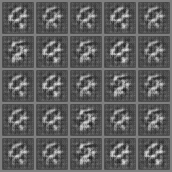

epoch: 5/100, batch: 360/1200, G_loss: -98.91905975341797, D_loss: (-101.9638900756836, 27.631019592285156)
epoch: 5/100, batch: 370/1200, G_loss: -83.99829864501953, D_loss: (-87.79939270019531, 27.631019592285156)
epoch: 5/100, batch: 380/1200, G_loss: -113.83980560302734, D_loss: (-114.39242553710938, 27.631019592285156)
epoch: 5/100, batch: 390/1200, G_loss: -109.97146606445312, D_loss: (-111.07670593261719, 27.631019592285156)
epoch: 5/100, batch: 400/1200, G_loss: -112.18194580078125, D_loss: (-113.83980560302734, 27.631019592285156)


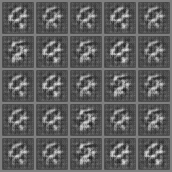

epoch: 5/100, batch: 410/1200, G_loss: -118.81338500976562, D_loss: (-118.58882904052734, 27.631019592285156)
epoch: 5/100, batch: 420/1200, G_loss: -84.5509262084961, D_loss: (-87.65589904785156, 27.631019592285156)
epoch: 5/100, batch: 430/1200, G_loss: -78.47209930419922, D_loss: (-82.09940338134766, 27.631019592285156)
epoch: 5/100, batch: 440/1200, G_loss: -78.47209167480469, D_loss: (-83.67927551269531, 27.631019592285156)
epoch: 5/100, batch: 450/1200, G_loss: -112.18194580078125, D_loss: (-113.83980560302734, 27.631019592285156)


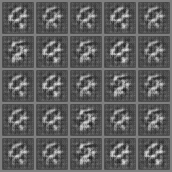

epoch: 5/100, batch: 460/1200, G_loss: -101.1295394897461, D_loss: (-103.73876953125, 27.631019592285156)
epoch: 5/100, batch: 470/1200, G_loss: -95.60333251953125, D_loss: (-97.23666381835938, 27.631019592285156)
epoch: 5/100, batch: 480/1200, G_loss: -87.31402587890625, D_loss: (-91.6506118774414, 27.631019592285156)
epoch: 5/100, batch: 490/1200, G_loss: -90.0771255493164, D_loss: (-91.73499298095703, 27.631019592285156)
epoch: 5/100, batch: 500/1200, G_loss: -66.86707305908203, D_loss: (-71.10385131835938, 27.631019592285156)


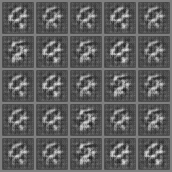

epoch: 5/100, batch: 510/1200, G_loss: -93.94546508789062, D_loss: (-96.70850372314453, 27.631019592285156)
epoch: 5/100, batch: 520/1200, G_loss: -75.70899200439453, D_loss: (-79.01174926757812, 27.631019592285156)
epoch: 5/100, batch: 530/1200, G_loss: -91.73499298095703, D_loss: (-93.9453353881836, 27.631019592285156)
epoch: 5/100, batch: 540/1200, G_loss: -112.73457336425781, D_loss: (-115.26319122314453, 27.631019592285156)
epoch: 5/100, batch: 550/1200, G_loss: -84.5509262084961, D_loss: (-87.31401062011719, 27.631019592285156)


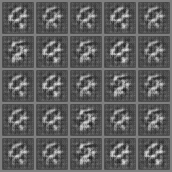

epoch: 5/100, batch: 560/1200, G_loss: -102.78739929199219, D_loss: (-104.89335632324219, 27.631019592285156)
epoch: 5/100, batch: 570/1200, G_loss: -88.97189331054688, D_loss: (-92.78512573242188, 27.631019592285156)
epoch: 5/100, batch: 580/1200, G_loss: -101.68215942382812, D_loss: (-103.34001922607422, 27.631019592285156)
epoch: 5/100, batch: 590/1200, G_loss: -93.39285278320312, D_loss: (-96.15596008300781, 27.631019592285156)
epoch: 5/100, batch: 600/1200, G_loss: -97.8138198852539, D_loss: (-100.5670394897461, 27.631019592285156)


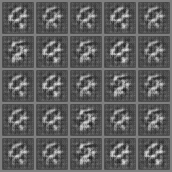

epoch: 5/100, batch: 610/1200, G_loss: -98.3664321899414, D_loss: (-101.55810546875, 27.631019592285156)
epoch: 5/100, batch: 620/1200, G_loss: -96.70857238769531, D_loss: (-100.01980590820312, 27.631019592285156)
epoch: 5/100, batch: 630/1200, G_loss: -107.760986328125, D_loss: (-109.41322326660156, 27.631019592285156)
epoch: 5/100, batch: 640/1200, G_loss: -74.05113220214844, D_loss: (-77.91947937011719, 27.631019592285156)
epoch: 5/100, batch: 650/1200, G_loss: -101.1295394897461, D_loss: (-102.69318389892578, 27.631019592285156)


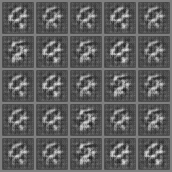

epoch: 5/100, batch: 660/1200, G_loss: -101.12953186035156, D_loss: (-100.5983657836914, 27.631019592285156)
epoch: 5/100, batch: 670/1200, G_loss: -117.15552520751953, D_loss: (-119.079345703125, 27.631019592285156)
epoch: 5/100, batch: 680/1200, G_loss: -84.55091857910156, D_loss: (-86.7599105834961, 27.631019592285156)
epoch: 5/100, batch: 690/1200, G_loss: -88.97189331054688, D_loss: (-92.367919921875, 27.631019592285156)
epoch: 5/100, batch: 700/1200, G_loss: -97.81381225585938, D_loss: (-99.95934295654297, 27.631019592285156)


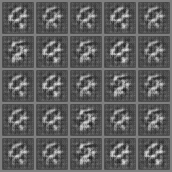

epoch: 5/100, batch: 710/1200, G_loss: -109.97146606445312, D_loss: (-111.07086181640625, 27.631019592285156)
epoch: 5/100, batch: 720/1200, G_loss: -100.02429962158203, D_loss: (-101.93789672851562, 27.631019592285156)
epoch: 5/100, batch: 730/1200, G_loss: -104.99787902832031, D_loss: (-107.75376892089844, 27.631019592285156)
epoch: 5/100, batch: 740/1200, G_loss: -85.10354614257812, D_loss: (-86.76140594482422, 27.631019592285156)
epoch: 5/100, batch: 750/1200, G_loss: -104.44525146484375, D_loss: (-107.20835876464844, 27.631019592285156)


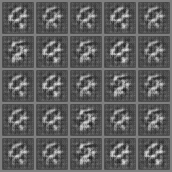

epoch: 5/100, batch: 760/1200, G_loss: -103.34001922607422, D_loss: (-105.42142486572266, 27.631019592285156)
epoch: 5/100, batch: 770/1200, G_loss: -97.8138198852539, D_loss: (-99.4716796875, 27.631019592285156)
epoch: 5/100, batch: 780/1200, G_loss: -87.86663818359375, D_loss: (-90.42845916748047, 27.631019592285156)
epoch: 5/100, batch: 790/1200, G_loss: -86.20878601074219, D_loss: (-87.85821533203125, 27.631019592285156)
epoch: 5/100, batch: 800/1200, G_loss: -90.62974548339844, D_loss: (-92.28759765625, 27.631019592285156)


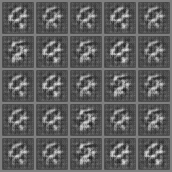

epoch: 5/100, batch: 810/1200, G_loss: -101.68215942382812, D_loss: (-103.34001159667969, 27.631019592285156)
epoch: 5/100, batch: 820/1200, G_loss: -111.07669830322266, D_loss: (-111.34461212158203, 27.631019592285156)
epoch: 5/100, batch: 830/1200, G_loss: -90.62974548339844, D_loss: (-95.60333251953125, 27.631019592285156)
epoch: 5/100, batch: 840/1200, G_loss: -98.91905212402344, D_loss: (-99.43174743652344, 27.631019592285156)
epoch: 5/100, batch: 850/1200, G_loss: -88.41926574707031, D_loss: (-90.0771255493164, 27.631019592285156)


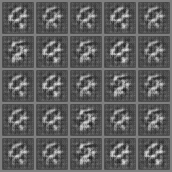

epoch: 5/100, batch: 860/1200, G_loss: -102.78739929199219, D_loss: (-104.95392608642578, 27.631019592285156)
epoch: 5/100, batch: 870/1200, G_loss: -100.02429962158203, D_loss: (-101.68215942382812, 27.631019592285156)
epoch: 5/100, batch: 880/1200, G_loss: -99.4716796875, D_loss: (-103.70525360107422, 27.631019592285156)
epoch: 5/100, batch: 890/1200, G_loss: -98.3664321899414, D_loss: (-100.02429962158203, 27.631019592285156)
epoch: 5/100, batch: 900/1200, G_loss: -93.39285278320312, D_loss: (-96.15589904785156, 27.631019592285156)


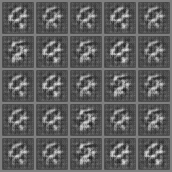

epoch: 5/100, batch: 910/1200, G_loss: -103.89263916015625, D_loss: (-106.10291290283203, 27.631019592285156)
epoch: 5/100, batch: 920/1200, G_loss: -101.68215942382812, D_loss: (-104.44526672363281, 27.631019592285156)
epoch: 5/100, batch: 930/1200, G_loss: -85.10354614257812, D_loss: (-88.38031005859375, 27.631019592285156)
epoch: 5/100, batch: 940/1200, G_loss: -100.57691192626953, D_loss: (-100.57691192626953, 27.631019592285156)
epoch: 5/100, batch: 950/1200, G_loss: -92.8402328491211, D_loss: (-93.94546508789062, 27.631019592285156)


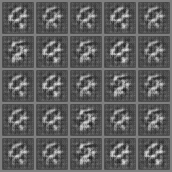

epoch: 5/100, batch: 960/1200, G_loss: -102.78739929199219, D_loss: (-104.44525146484375, 27.631019592285156)
epoch: 5/100, batch: 970/1200, G_loss: -99.4716796875, D_loss: (-97.08067321777344, 27.631019592285156)
epoch: 5/100, batch: 980/1200, G_loss: -101.68215942382812, D_loss: (-104.99536895751953, 27.631019592285156)
epoch: 5/100, batch: 990/1200, G_loss: -96.70857238769531, D_loss: (-98.68681335449219, 27.631019592285156)
epoch: 5/100, batch: 1000/1200, G_loss: -90.62974548339844, D_loss: (-95.60331726074219, 27.631019592285156)


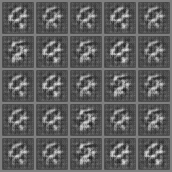

epoch: 5/100, batch: 1010/1200, G_loss: -99.4716796875, D_loss: (-101.7000503540039, 27.631019592285156)
epoch: 5/100, batch: 1020/1200, G_loss: -89.5245132446289, D_loss: (-91.182373046875, 27.631019592285156)
epoch: 5/100, batch: 1030/1200, G_loss: -103.34001922607422, D_loss: (-106.05493927001953, 27.631019592285156)
epoch: 5/100, batch: 1040/1200, G_loss: -106.1031265258789, D_loss: (-109.41822052001953, 27.631019592285156)
epoch: 5/100, batch: 1050/1200, G_loss: -101.68215942382812, D_loss: (-103.34001922607422, 27.631019592285156)


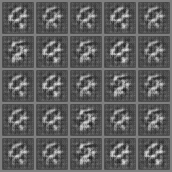

epoch: 5/100, batch: 1060/1200, G_loss: -87.31402587890625, D_loss: (-93.11697387695312, 27.631019592285156)
epoch: 5/100, batch: 1070/1200, G_loss: -91.73499298095703, D_loss: (-93.7832260131836, 27.631019592285156)
epoch: 5/100, batch: 1080/1200, G_loss: -101.68215942382812, D_loss: (-102.78739929199219, 27.631019592285156)
epoch: 5/100, batch: 1090/1200, G_loss: -86.76140594482422, D_loss: (-91.73455047607422, 27.631019592285156)
epoch: 5/100, batch: 1100/1200, G_loss: -95.05071258544922, D_loss: (-98.15252685546875, 27.631019592285156)


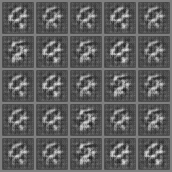

epoch: 5/100, batch: 1110/1200, G_loss: -102.78739166259766, D_loss: (-105.86418914794922, 27.631019592285156)
epoch: 5/100, batch: 1120/1200, G_loss: -98.91905212402344, D_loss: (-100.02429962158203, 27.631019592285156)
epoch: 5/100, batch: 1130/1200, G_loss: -100.02429962158203, D_loss: (-103.29691314697266, 27.631019592285156)
epoch: 5/100, batch: 1140/1200, G_loss: -86.76140594482422, D_loss: (-89.5190200805664, 27.631019592285156)
epoch: 5/100, batch: 1150/1200, G_loss: -104.99789428710938, D_loss: (-106.10311889648438, 27.631019592285156)


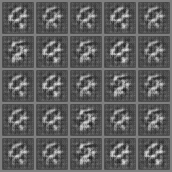

epoch: 5/100, batch: 1160/1200, G_loss: -79.57734680175781, D_loss: (-77.9863052368164, 27.631019592285156)
epoch: 5/100, batch: 1170/1200, G_loss: -99.4716796875, D_loss: (-100.57691192626953, 27.631019592285156)
epoch: 5/100, batch: 1180/1200, G_loss: -84.5509262084961, D_loss: (-87.31402587890625, 27.631019592285156)
epoch: 5/100, batch: 1190/1200, G_loss: -94.49808502197266, D_loss: (-96.76591491699219, 27.631019592285156)
epoch: 6/100, batch: 0/1200, G_loss: -92.2876205444336, D_loss: (-95.5602798461914, 27.631019592285156)


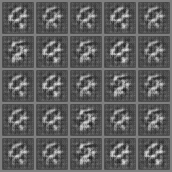

epoch: 6/100, batch: 10/1200, G_loss: -106.1031265258789, D_loss: (-106.92842864990234, 27.631019592285156)
epoch: 6/100, batch: 20/1200, G_loss: -82.34043884277344, D_loss: (-83.99829864501953, 27.631019592285156)
epoch: 6/100, batch: 30/1200, G_loss: -86.20878601074219, D_loss: (-88.36111450195312, 27.631019592285156)
epoch: 6/100, batch: 40/1200, G_loss: -101.68216705322266, D_loss: (-103.34001922607422, 27.631019592285156)
epoch: 6/100, batch: 50/1200, G_loss: -82.34043884277344, D_loss: (-85.6509780883789, 27.631019592285156)


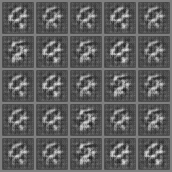

epoch: 6/100, batch: 60/1200, G_loss: -108.31360626220703, D_loss: (-111.07670593261719, 27.631019592285156)
epoch: 6/100, batch: 70/1200, G_loss: -84.5509262084961, D_loss: (-88.41926574707031, 27.631019592285156)
epoch: 6/100, batch: 80/1200, G_loss: -87.31402587890625, D_loss: (-90.0771255493164, 27.631019592285156)
epoch: 6/100, batch: 90/1200, G_loss: -109.97146606445312, D_loss: (-111.07670593261719, 27.631019592285156)
epoch: 6/100, batch: 100/1200, G_loss: -100.02429962158203, D_loss: (-102.23477172851562, 27.631019592285156)


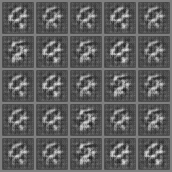

epoch: 6/100, batch: 110/1200, G_loss: -83.99829864501953, D_loss: (-88.41602325439453, 27.631019592285156)
epoch: 6/100, batch: 120/1200, G_loss: -86.20878601074219, D_loss: (-90.01666259765625, 27.631019592285156)
epoch: 6/100, batch: 130/1200, G_loss: -92.28760528564453, D_loss: (-96.14525604248047, 27.631019592285156)
epoch: 6/100, batch: 140/1200, G_loss: -70.18279266357422, D_loss: (-76.2065658569336, 27.631019592285156)
epoch: 6/100, batch: 150/1200, G_loss: -107.760986328125, D_loss: (-109.4188461303711, 27.631019592285156)


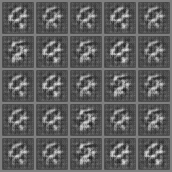

epoch: 6/100, batch: 160/1200, G_loss: -103.34001922607422, D_loss: (-105.26924133300781, 27.631019592285156)
epoch: 6/100, batch: 170/1200, G_loss: -91.73500061035156, D_loss: (-96.07839965820312, 27.631019592285156)
epoch: 6/100, batch: 180/1200, G_loss: -97.26119232177734, D_loss: (-98.89490509033203, 27.631019592285156)
epoch: 6/100, batch: 190/1200, G_loss: -85.10354614257812, D_loss: (-89.524169921875, 27.631019592285156)
epoch: 6/100, batch: 200/1200, G_loss: -96.15594482421875, D_loss: (-97.7509536743164, 27.631019592285156)


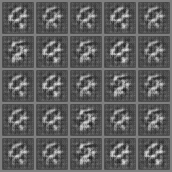

epoch: 6/100, batch: 210/1200, G_loss: -96.15596008300781, D_loss: (-97.8136215209961, 27.631019592285156)
epoch: 6/100, batch: 220/1200, G_loss: -108.31360626220703, D_loss: (-109.4188461303711, 27.631019592285156)
epoch: 6/100, batch: 230/1200, G_loss: -82.34043884277344, D_loss: (-83.28722381591797, 27.631019592285156)
epoch: 6/100, batch: 240/1200, G_loss: -95.60333251953125, D_loss: (-97.81365203857422, 27.631019592285156)
epoch: 6/100, batch: 250/1200, G_loss: -101.1295394897461, D_loss: (-103.89208984375, 27.631019592285156)


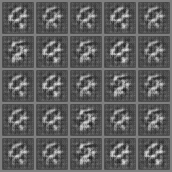

epoch: 6/100, batch: 260/1200, G_loss: -92.8402328491211, D_loss: (-95.05071258544922, 27.631019592285156)
epoch: 6/100, batch: 270/1200, G_loss: -101.68215942382812, D_loss: (-103.26195526123047, 27.631019592285156)
epoch: 6/100, batch: 280/1200, G_loss: -113.28718566894531, D_loss: (-115.4976577758789, 27.631019592285156)
epoch: 6/100, batch: 290/1200, G_loss: -93.94548034667969, D_loss: (-96.15596008300781, 27.631019592285156)
epoch: 6/100, batch: 300/1200, G_loss: -83.44568634033203, D_loss: (-85.01866912841797, 27.631019592285156)


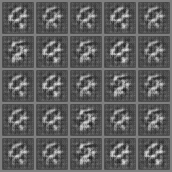

epoch: 6/100, batch: 310/1200, G_loss: -84.5509262084961, D_loss: (-88.41926574707031, 27.631019592285156)
epoch: 6/100, batch: 320/1200, G_loss: -70.73541259765625, D_loss: (-76.81423950195312, 27.631019592285156)
epoch: 6/100, batch: 330/1200, G_loss: -81.2352066040039, D_loss: (-85.1035385131836, 27.631019592285156)
epoch: 6/100, batch: 340/1200, G_loss: -93.39285278320312, D_loss: (-96.15596008300781, 27.631019592285156)
epoch: 6/100, batch: 350/1200, G_loss: -102.78739929199219, D_loss: (-107.20835876464844, 27.631019592285156)


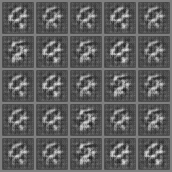

In [0]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples,label) in enumerate(data_loader):
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        label = Variable(label).cuda().type(torch.cuda.FloatTensor)
        
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, label)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % batch_size == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val).data.cpu()
            display_batch_images(val_fake_samples)